# Классификация жанров фильмов по описанию сюжета (27 классов)
## Цель

Применить RNN и трансформеры для многоклассовой классификации текста.

Оценить влияние предобработки и гиперпараметров.

Сравнить подходы: TF-IDF+MLP → эмбеддинги+RNN/FFNN → трансформеры.

Собрать метрики (macro-F1 как основная), визуализации и анализ ошибок.

Логировать всё в MLflow и подготовить submission.csv.

## Данные

train_7oo3RES.csv: колонки name, genre, text (≈54k строк, 27 жанров).

test_1xq7msG.csv: колонки name, text (без genre).

Сплит: 80/10/10 (train/val/hold), стратифицированный по метке.

## EDA (exploratory data analysis)

Баланс классов, доля дубликатов, распределение длин текстов.

Частотный анализ токенов/н-грамм.

Выводы по дисбалансу: ориентируемся на macro-F1, а не accuracy.

## Предобработка текста (две линии)

classic_text (для TF-IDF и RNN/FFNN):
нормализация, deaccent, очистка URL/почт, пунктуация, стоп-слова, стемм/лемма.

neural_text (для трансформеров):
минимальная нормализация (убрать мусор/URL).

## Модели и представления текста
### TF-IDF + MLP (базовая нейросеть)

Векторизация: TF-IDF word 1–2 (до 200k фич).

Модель: MLP (512→256→128, ReLU, α=1e-4), adaptive LR, ранняя остановка.

Что проверяем: влияние n-грамм, max_features, L2 (alpha), скрытых слоёв.

Визуализации: loss-кривые, macro-F1 кривая, confusion matrix, PR-кривые (top-k), ROC-micro.
Бонус: поверхность качества (теплокарта macro-F1 по сетке alpha × hidden).

### Эмбеддинги + FFNN / BiGRU

Эмбеддинги: self-trained Word2Vec на корпусе (200d, min_count=2).

FFNN: среднее по токенам → MLP (256→128).

BiGRU: двунаправленная GRU, max-pool, dropout.

Баланс: class weights в CrossEntropy.

Тренировка: до 60 эпох, patience=3, clip-grad, LR scheduler по val macro-F1.

Визуализации: как в 5.1.

### Трансформеры

Модели:

DistilBERT (distilbert-base-uncased) — сильная база, быстро.

MiniLM (microsoft/MiniLM-L12-H384-uncased) — отличное качество/скорость.

DistilRoBERTa (distilroberta-base) — часто +1–3 п.п. macro-F1.

Токенизация: модельная, max_len (обычно 192 или 224 при VRAM 8GB), AMP.

Потери/баланс: class weights в CE.

Тренировка: max 60 эпох, ранняя остановка (patience=3), clip-grad, AdamW, ReduceLROnPlateau.

Визуализации: как в 5.1 + сохранение логитов для PR/ROC.

## Гиперпараметры 

TF-IDF+MLP:
ngram_range ∈ {(1,1),(1,2)}, max_features ∈ {100k,200k}, alpha ∈ {1e-5…1e-3}, hidden ∈ {128,256,512}.
Быстрый скан + теплокарта macro-F1.

BiGRU/FFNN:
emb_dim ∈ {100,200}, hidden ∈ {128,256}, dropout ∈ {0.3,0.5}, lr ∈ {1e-3,5e-4}.

Transformers:
max_len ∈ {128,192,224}, lr ∈ {2e-5,3e-5}, bs ∈ {8,16}, patience ∈ {2,3}.
Короткие 2–3 эпохи на val для выбора пары, затем «короткий таргет-ран» с ES.

## Метрики и визуализации

Основная метрика: macro-F1 (дисбаланс классов).

Также: accuracy, macro-precision/recall, per-class F1.

Визуализации:

Curves: train loss, val macro-F1.

Confusion Matrix (val/hold).

PR-кривые: per-class (top-k по поддержке), micro/macro AP.

ROC: micro (для полноты).

Loss surface для MLP.

Всё сохраняется в artifacts/reports и логируется в MLflow.

## Анализ ошибок

Топ-пары путаниц (off-diagonal в CM).

Выборки FP/FN для этих пар с примерами текстов.

N-граммы/токены, ассоциированные с ошибками (по TF-IDF весам или важностям).

## MLflow

Эксперимент: movie-genre-nlp.

Для каждого ран-нейма: логируем параметры, метрики по эпохам, артефакты (CM, curves, PR/ROC, surface).

Теги: prep=classic_text/neural_text, model={mlp,bigru,ffnn,distilbert,minilm,distilroberta}.

## Сабмит и инференс

Лучшая модель по val macro-F1 → предсказываем genre для теста.

submission.csv с колонками name, genre

In [2]:
import json
import gc
import glob
import math
import os
import random
import re
import time
import warnings
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import spacy, contractions
import torch
import torch.nn.functional as F
import torch.nn as nn

from collections import Counter
from gensim.models import Word2Vec, FastText
from gensim.models.phrases import Phrases, Phraser
from itertools import islice
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from PIL import Image
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup, DataCollatorWithPadding
)
from typing import Tuple, Dict

warnings.filterwarnings("ignore")
sns.set_context("talk")

# Пути и сиды
ROOT = Path(r"D:/ML/LS/Deep_learning/NLP/practice")
ART  = ROOT / "artifacts"
(ART/"reports").mkdir(parents=True, exist_ok=True)
(ART/"models").mkdir(parents=True, exist_ok=True)
(ART/"submissions").mkdir(parents=True, exist_ok=True)
(ART/"mlflow_artifacts").mkdir(parents=True, exist_ok=True)

SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
seed_everything()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
TRAIN_CSV = ROOT/"train_7oo3RES.csv"
TEST_CSV  = ROOT/"test_1xq7msG.csv"

df = pd.read_csv(TRAIN_CSV)
df["text"] = df["text"].astype(str)

le = LabelEncoder()
df["label"] = le.fit_transform(df["genre"])
id2label = {i:c for i,c in enumerate(le.classes_)}
label2id = {c:i for i,c in id2label.items()}

train_df, hold_df = train_test_split(df, test_size=0.10, random_state=SEED, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.1111, random_state=SEED, stratify=train_df["label"])  # 0.1111*0.9 ≈ 0.10

## базовые EDA-хелперы


== train ==
classes: 27


genre
drama          10890
documentary    10476
comedy          5957
short           4059
horror          1764
thriller        1273
action          1052
western          826
reality-tv       708
family           628
adventure        619
music            585
romance          538
sci-fi           517
adult            472
Name: count, dtype: int64

duplicate texts: 0.20%
len: mean=101.9 | median=79.0 | p95=242


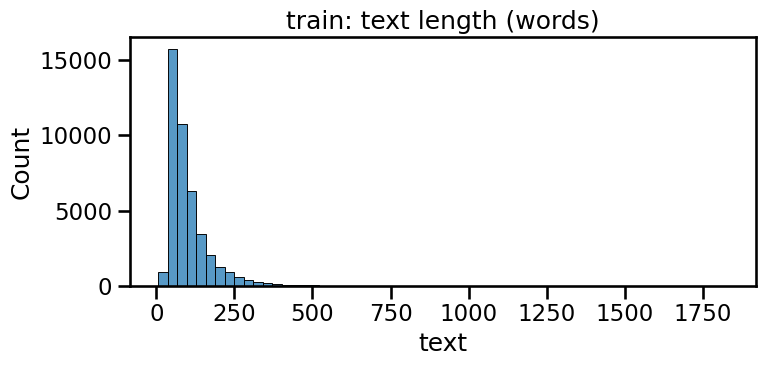

top tokens: [('josiah', 6), ('and', 152922), ('michelle', 104), ('rutabaga', 1), (',', 249441), ('with', 42086), ('the', 268095), ('reluctant', 146), ('help', 3496), ('of', 134003), ('their', 25948), ('daughter', 3132), ('gemma', 15), ('run', 1369), ('a', 141875), ('potato', 28), ('stall', 25), ('in', 87886), ('driveway', 6), ('named', 1504)]

== val ==
classes: 27


genre
drama          1361
documentary    1310
comedy          745
short           507
horror          220
thriller        159
action          131
western         103
reality-tv       88
family           78
adventure        78
music            73
romance          67
sci-fi           65
adult            59
Name: count, dtype: int64

duplicate texts: 0.02%
len: mean=102.8 | median=79.0 | p95=249


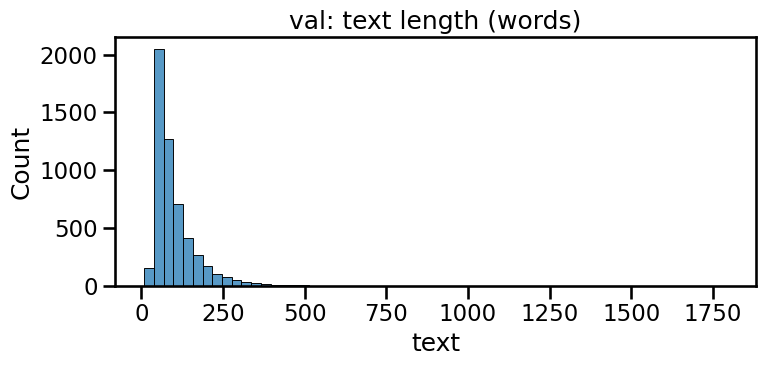

top tokens: [('all', 1385), ('things', 253), ('shining', 6), ('"', 3762), ('is', 8312), ('an', 2928), ('experimental', 42), (',', 31180), ('intermedial', 1), ('dramatic', 56), ('live', 382), ('cinema', 70), ('experience', 163), ('.', 28499), ('at', 2061), ('its', 513), ('heart', 196), ('it', 2097), ('a', 17820), ('story', 1024)]

== hold ==
classes: 27


genre
drama          1362
documentary    1310
comedy          745
short           507
horror          220
thriller        159
action          132
western         103
reality-tv       88
adventure        78
family           78
music            73
romance          67
sci-fi           65
adult            59
Name: count, dtype: int64

duplicate texts: 0.07%
len: mean=100.7 | median=78.0 | p95=237


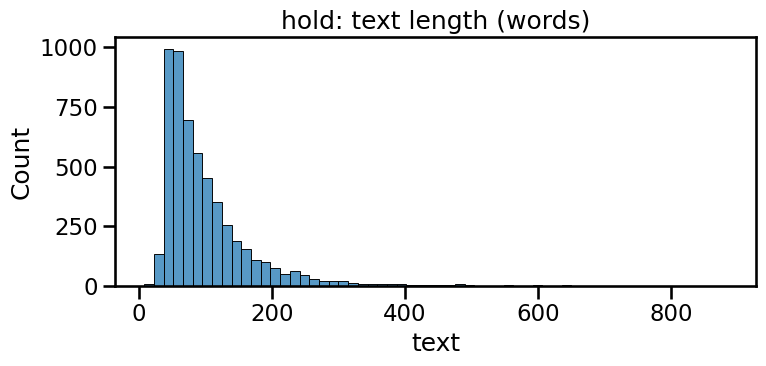

top tokens: [('zachary', 7), ('primeval', 2), ('has', 2193), ('a', 17449), ('successful', 115), ('life', 1824), ('in', 11074), ('san', 85), ('francisco', 43), ('.', 27344), ('but', 2196), ('after', 1101), ('his', 6622), ('daughter', 371), ('gets', 352), ('killed', 151), ('during', 384), ('robbery', 26), (',', 30798), ('falls', 221)]


In [15]:
# EDA helpers 

def basic_tok(s):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+|\S", str(s))

def show_eda(d: pd.DataFrame, name: str):
    print(f"\n== {name} ==")
    vc = d["genre"].value_counts()
    print("classes:", vc.shape[0])
    display(vc.head(15))

    dup_rate = 1 - d["text"].nunique()/len(d)
    print(f"duplicate texts: {dup_rate:.2%}")

    lens = d["text"].str.split().apply(len)
    print(f"len: mean={lens.mean():.1f} | median={lens.median()} | p95={np.percentile(lens,95):.0f}")

    plt.figure(figsize=(8,4))
    sns.histplot(lens, bins=60)
    plt.title(f"{name}: text length (words)")
    plt.tight_layout()
    plt.savefig(ART/"reports"/f"{name}_length_hist.png", dpi=160)
    plt.show()

    toks = (t.lower() for x in d["text"] for t in basic_tok(x))
    from collections import Counter
    print("top tokens:", list(islice(Counter(toks).items(), 20)))

show_eda(train_df, "train")
show_eda(val_df,   "val")
show_eda(hold_df,  "hold")

## Распределение классов (top-20)


[train] classes=27


count     share
genre                       
drama        10890  0.251089
documentary  10476  0.241544
comedy        5957  0.137350
short         4059  0.093588
horror        1764  0.040672
thriller      1273  0.029351
action        1052  0.024256
western        826  0.019045
reality-tv     708  0.016324
family         628  0.014480
adventure      619  0.014272
music          585  0.013488
romance        538  0.012405
sci-fi         517  0.011920
adult          472  0.010883

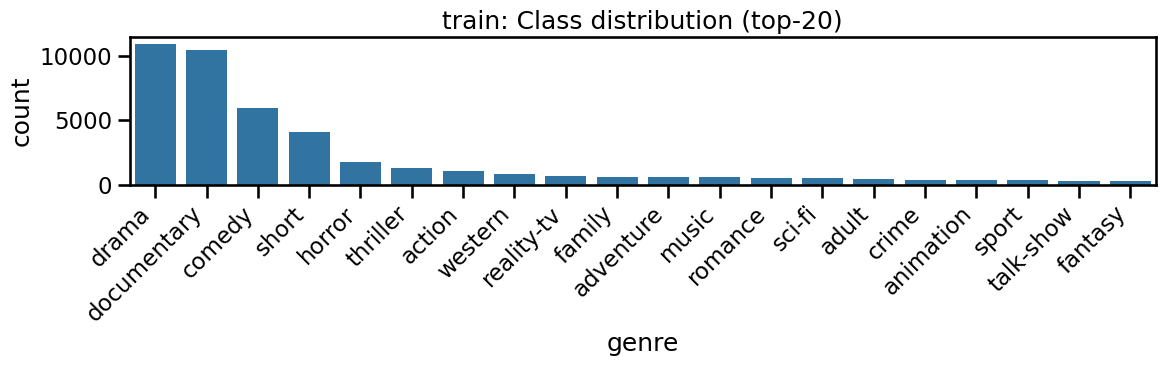


[val] classes=27


count     share
genre                       
drama         1361  0.251061
documentary   1310  0.241653
comedy         745  0.137429
short          507  0.093525
horror         220  0.040583
thriller       159  0.029330
action         131  0.024165
western        103  0.019000
reality-tv      88  0.016233
family          78  0.014388
adventure       78  0.014388
music           73  0.013466
romance         67  0.012359
sci-fi          65  0.011990
adult           59  0.010884

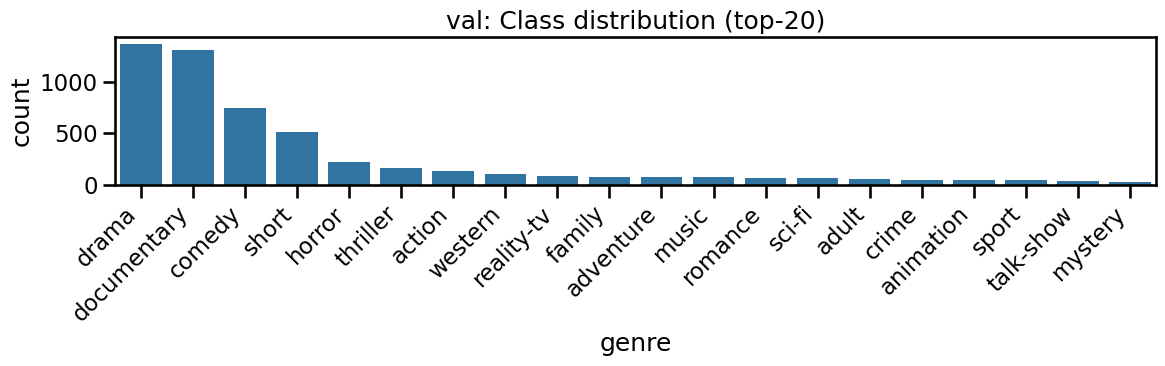


[hold] classes=27


count     share
genre                       
drama         1362  0.251199
documentary   1310  0.241608
comedy         745  0.137403
short          507  0.093508
horror         220  0.040575
thriller       159  0.029325
action         132  0.024345
western        103  0.018997
reality-tv      88  0.016230
adventure       78  0.014386
family          78  0.014386
music           73  0.013464
romance         67  0.012357
sci-fi          65  0.011988
adult           59  0.010882

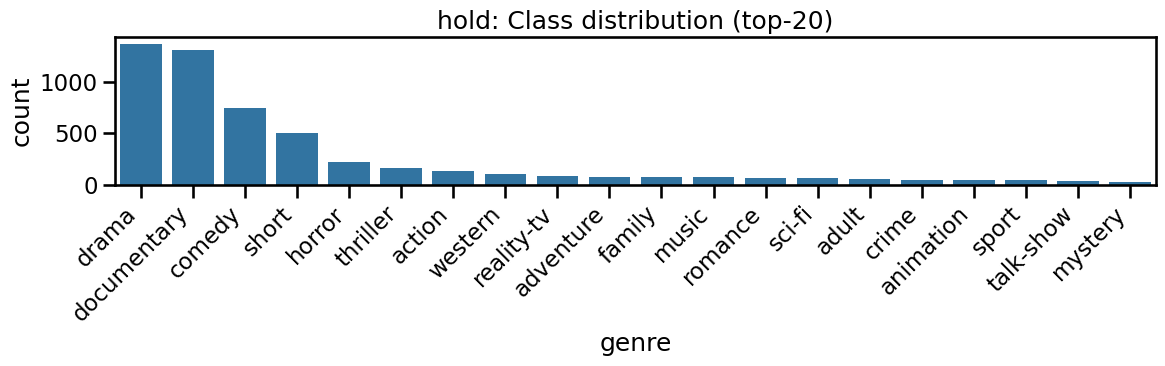

In [26]:
def plot_class_dist(df_part, name):
    vc = df_part["genre"].value_counts()
    vc_norm = df_part["genre"].value_counts(normalize=True)
    print(f"\n[{name}] classes={vc.shape[0]}")
    display(pd.DataFrame({"count": vc, "share": vc_norm}).head(15))

    plt.figure(figsize=(12,4))
    order = vc.index[:20]
    sns.barplot(x=vc.loc[order].index, y=vc.loc[order].values)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{name}: Class distribution (top-20)")
    plt.ylabel("count"); plt.xlabel("genre")
    plt.tight_layout()
    plt.savefig(ART/"reports"/f"{name}_class_dist_top20.png", dpi=160)
    plt.show()

plot_class_dist(train_df, "train")
plot_class_dist(val_df,   "val")
plot_class_dist(hold_df,  "hold")

## Длины текстов (hist + box по top-8 жанрам)

          len_chars     len_words
count  43371.000000  43371.000000
mean     600.708123    101.949667
std      446.621749     76.623716
min       42.000000      6.000000
50%      464.000000     79.000000
90%     1093.000000    186.000000
95%     1425.000000    242.000000
99%     2266.000000    390.000000
max    10504.000000   1829.000000


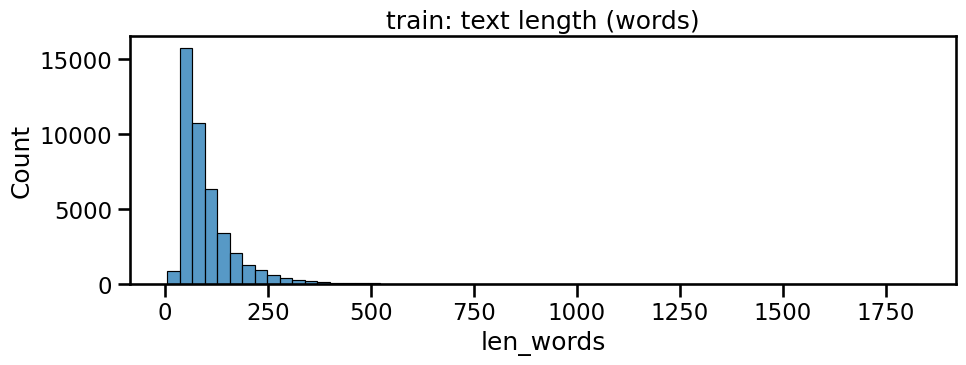

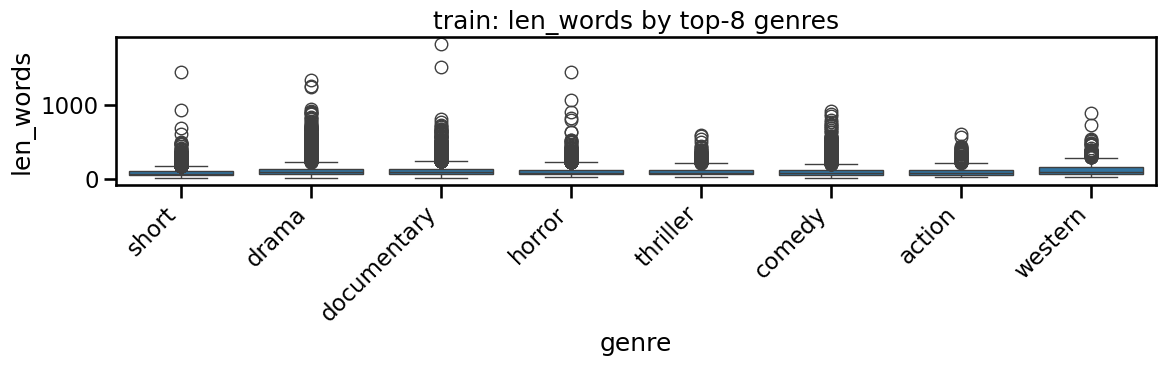

          len_chars    len_words
count   5421.000000  5421.000000
mean     605.176167   102.808338
std      459.771661    79.418463
min       68.000000     9.000000
50%      462.000000    79.000000
90%     1130.000000   189.000000
95%     1444.000000   249.000000
99%     2306.600000   394.000000
max    10019.000000  1793.000000


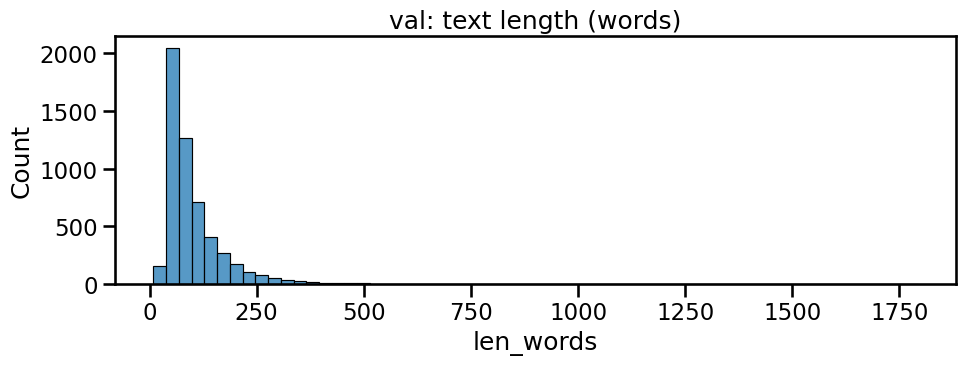

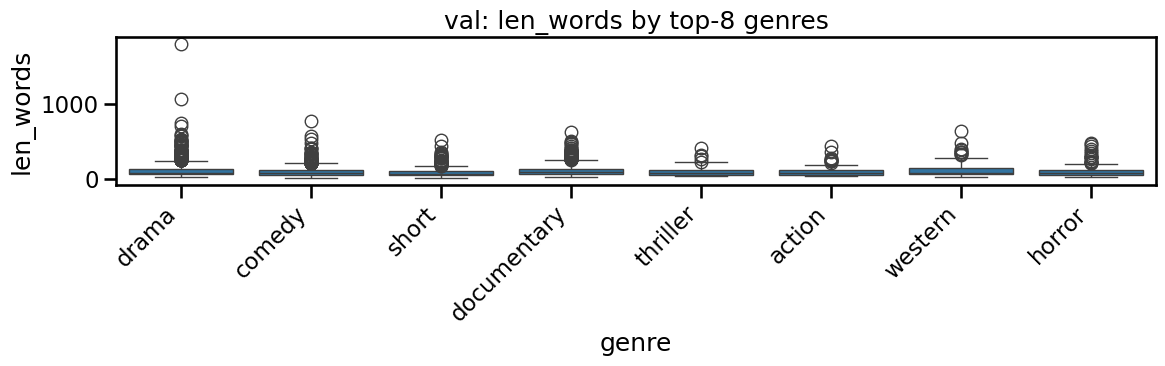

         len_chars    len_words
count  5422.000000  5422.000000
mean    593.684249   100.668388
std     426.903299    73.258211
min      48.000000     8.000000
50%     462.000000    78.000000
90%    1076.000000   183.000000
95%    1387.000000   237.000000
99%    2248.000000   398.790000
max    5073.000000   884.000000


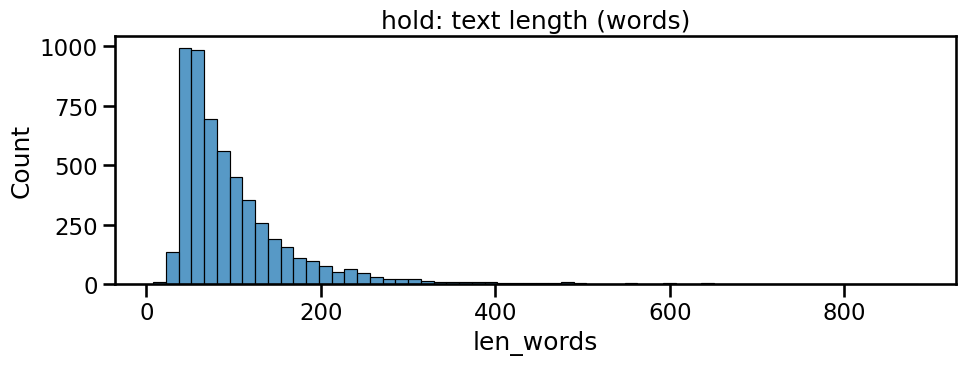

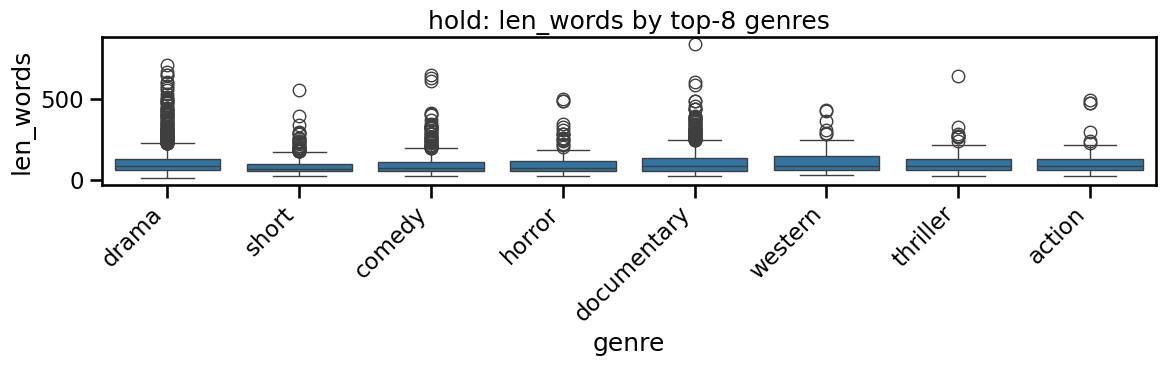

In [27]:
def add_lengths(df_part):
    df_part["len_chars"] = df_part["text"].str.len()
    df_part["len_words"] = df_part["text"].str.split().apply(len)

for d in (train_df, val_df, hold_df):
    add_lengths(d)

def plot_lengths(df_part, name):
    print(df_part[["len_chars","len_words"]].describe(percentiles=[.5,.9,.95,.99]))
    plt.figure(figsize=(10,4))
    sns.histplot(df_part["len_words"], bins=60)
    plt.title(f"{name}: text length (words)")
    plt.tight_layout(); plt.savefig(ART/"reports"/f"{name}_len_words_hist.png", dpi=160); plt.show()

    top8 = df_part["genre"].value_counts().index[:8]
    plt.figure(figsize=(12,4))
    sns.boxplot(data=df_part[df_part["genre"].isin(top8)], x="genre", y="len_words")
    plt.xticks(rotation=45, ha="right"); plt.title(f"{name}: len_words by top-8 genres")
    plt.tight_layout(); plt.savefig(ART/"reports"/f"{name}_len_words_box_top8.png", dpi=160); plt.show()

plot_lengths(train_df, "train")
plot_lengths(val_df,   "val")
plot_lengths(hold_df,  "hold")

## Стоп-слова, нормализация и neural_text

In [16]:
# стоп-слова: sklearn + исключаем отрицания

CUSTOM_STOP = set()  
BASE_STOP = set(ENGLISH_STOP_WORDS) | CUSTOM_STOP
for w in ["no", "not", "nor", "never", "n't"]:
    BASE_STOP.discard(w)

def deaccent(s: str) -> str:
    import unicodedata
    return unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")

def norm_space(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

URL_RE    = re.compile(r"http\S+|www\.\S+")
EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
BAD_QUOTE = str.maketrans({"’":"'", "“":'"', "”":'"'})

def clean_neural(s: str) -> str:
    s = str(s).replace("\u200b"," ").replace("\ufeff"," ")
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)
    s = s.translate(BAD_QUOTE)
    return norm_space(s)

for d in (train_df, val_df, hold_df):
    d["neural_text"] = d["text"].apply(clean_neural)

display(train_df[["text","neural_text"]].head(3))

text  \
47166   Josiah and Michelle Rutabaga, with the reluct...   
15834   Three women approaching 30 find themselves in...   
2518    Melli (19) is getting out of juvenile hall af...   

                                             neural_text  
47166  Josiah and Michelle Rutabaga, with the relucta...  
15834  Three women approaching 30 find themselves in ...  
2518   Melli (19) is getting out of juvenile hall aft...

## spaCy-классика + gensim биграммы + classic_text

In [17]:
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])  # токенайзер+POS+лемма

KEEP_POS = {"NOUN", "PROPN", "VERB", "ADJ", "ADV"}

def classic_pipeline_iter(texts, lower=True, deacc=False, rm_digits=False):
    """Генератор списков токенов (до биграмм)."""
    prepped = []
    for s in texts:
        s = str(s).replace("\u200b"," ").replace("\ufeff"," ")
        s = URL_RE.sub(" ", s)
        s = EMAIL_RE.sub(" ", s)
        s = s.translate(BAD_QUOTE)
        s = contractions.fix(s)               # can't -> cannot
        if lower: s = s.lower()
        if deacc: s = deaccent(s)
        prepped.append(s)

    for doc in nlp.pipe(prepped, batch_size=1024, n_process=1):
        toks = []
        for t in doc:
            if t.is_space or t.is_punct:
                continue
            if rm_digits and t.like_num:
                continue
            lemma = (t.lemma_ or t.text).strip()
            if not lemma:
                continue
            if lemma in BASE_STOP:
                continue
            if t.pos_ not in KEEP_POS:
                continue
            toks.append(lemma)
        yield toks

train_tokens = list(classic_pipeline_iter(
    train_df["text"].tolist(), lower=True, deacc=False, rm_digits=False
))

phrases = Phrases(
    train_tokens,
    min_count=10,
    threshold=10.0,
    delimiter="_"      # строковый delimiter
)
bigram = Phraser(phrases)

def tokens_to_text(tokens):
    return norm_space(" ".join(tokens))

def build_classic_text(df_part: pd.DataFrame) -> pd.Series:
    out = []
    for toks in classic_pipeline_iter(df_part["text"].tolist(), lower=True, deacc=False, rm_digits=False):
        toks = bigram[toks]
        out.append(tokens_to_text(toks))
    return pd.Series(out, index=df_part.index)

train_df["classic_text"] = build_classic_text(train_df)
val_df["classic_text"]   = build_classic_text(val_df)
hold_df["classic_text"]  = build_classic_text(hold_df)

display(train_df[["text","classic_text","neural_text"]].head(3))

text  \
47166   Josiah and Michelle Rutabaga, with the reluct...   
15834   Three women approaching 30 find themselves in...   
2518    Melli (19) is getting out of juvenile hall af...   

                                            classic_text  \
47166  josiah michelle rutabaga reluctant help daught...   
15834  woman approach vary degree unfortunate romance...   
2518   melli juvenile hall good month promise trouble...   

                                             neural_text  
47166  Josiah and Michelle Rutabaga, with the relucta...  
15834  Three women approaching 30 find themselves in ...  
2518   Melli (19) is getting out of juvenile hall aft...

## wordclouds по жанрам

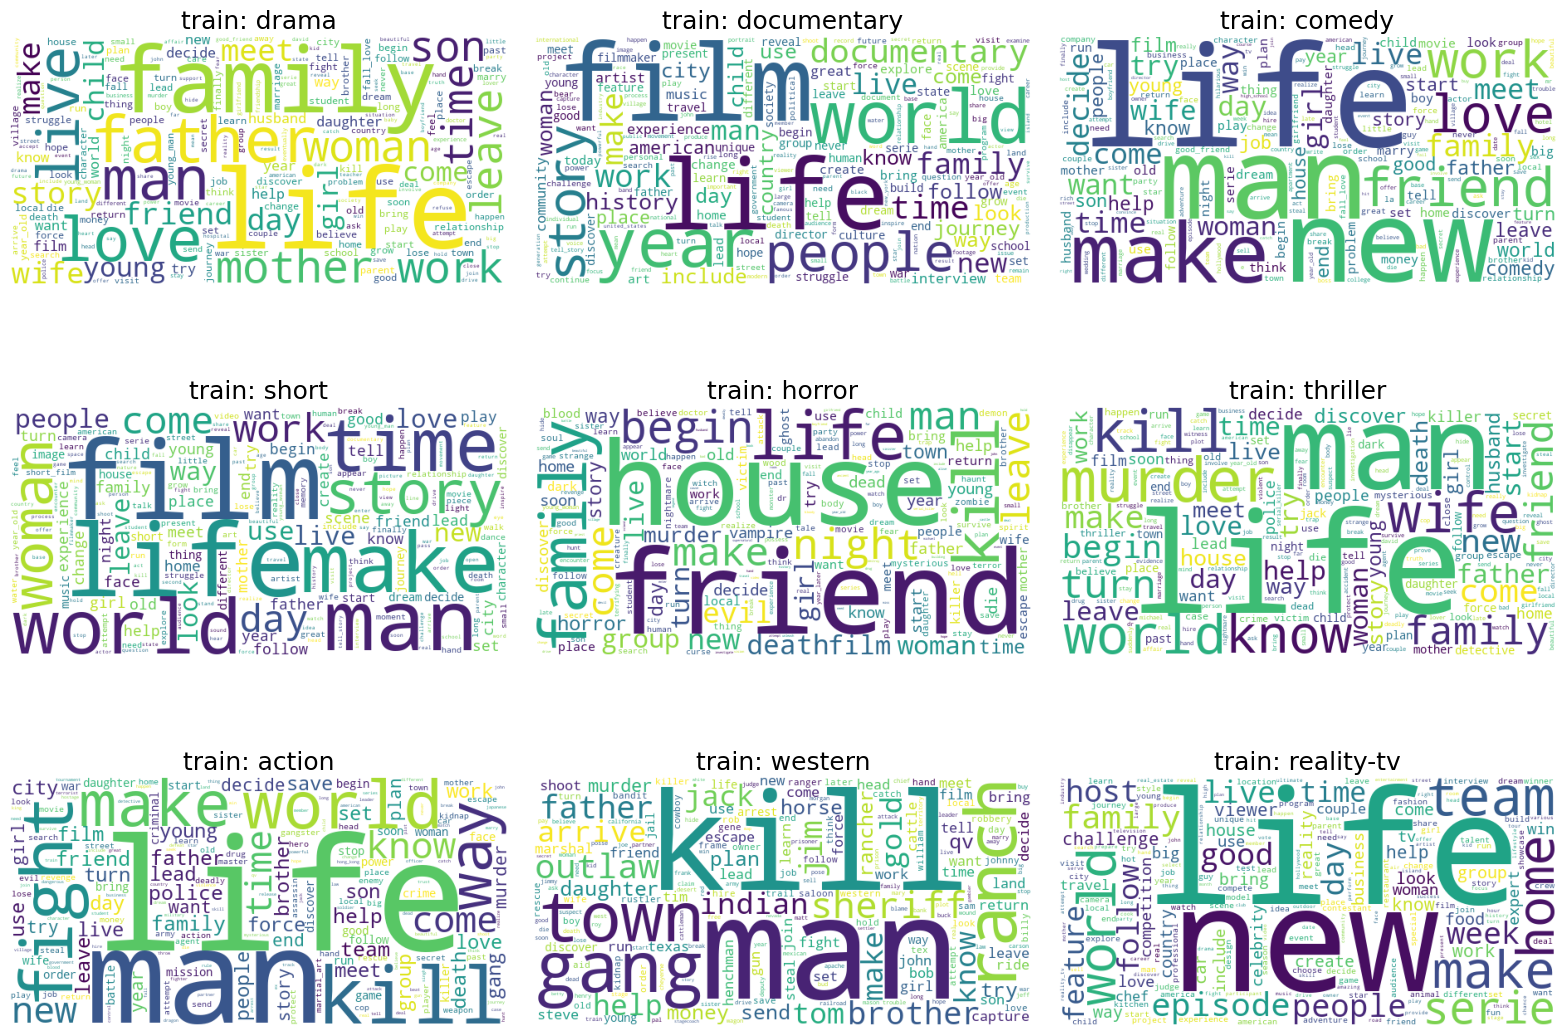

In [30]:
from wordcloud import WordCloud

def plot_wordclouds(df_part, name, k=9):
    topk = df_part["genre"].value_counts().index[:k]
    ncols = 3; nrows = int(np.ceil(k/ncols))
    plt.figure(figsize=(16, 4*nrows))
    for i, g in enumerate(topk, 1):
        txt = " ".join(df_part.loc[df_part["genre"]==g, "classic_text"].values)
        wc = WordCloud(width=600, height=300, background_color="white").generate(txt)
        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(wc); ax.axis("off"); ax.set_title(f"{name}: {g}")
    plt.tight_layout()
    plt.savefig(ART/"reports"/f"{name}_wordcloud_top{k}.png", dpi=160)
    plt.show()

plot_wordclouds(train_df, "train", k=9)

## TF-IDF топ-термы по жанрам

genre  rank         term     score
0         drama     1         life  0.023367
1         drama     2       family  0.016562
2         drama     3       father  0.014263
3         drama     4         love  0.014189
4         drama     5          man  0.013080
5         drama     6        story  0.012565
6         drama     7       mother  0.012329
7         drama     8         live  0.012302
8         drama     9        young  0.011923
9         drama    10          son  0.011681
10        drama    11        woman  0.011627
11        drama    12         wife  0.010502
12        drama    13       friend  0.010276
13        drama    14        leave  0.010083
14        drama    15     daughter  0.010010
15  documentary     1         film  0.023208
16  documentary     2  documentary  0.018429
17  documentary     3         life  0.017293
18  documentary     4        world  0.016433
19  documentary     5       people  0.014717
20  documentary     6         year  0.013880
21  documentary     7        story  0.013827
22  documentary     8      history  0.010032
23  documentary     9         work  0.009866
24  documentary    10         time  0.009737
25  documentary    11         make  0.009550
26  documentary    12       family  0.008899
27  documentary    13         live  0.008884
28  documentary    14       follow  0.008843
29  documentary    15      journey  0.008686

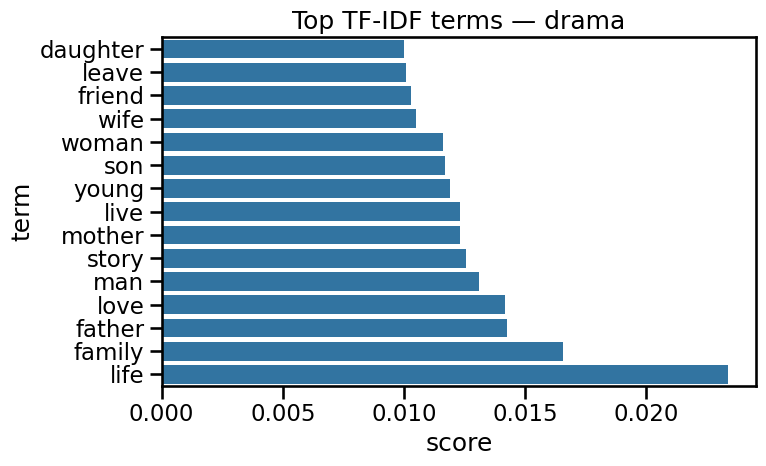

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=200_000)
Xtr_tfidf = tfidf.fit_transform(train_df["classic_text"])

def top_terms_per_class(df_part, X, label_col="genre", topk=15, classes=None):
    if classes is None:
        classes = df_part[label_col].value_counts().index[:6]
    terms = np.array(tfidf.get_feature_names_out())
    rows = []
    for g in classes:
        idx = (df_part[label_col]==g).values
        if idx.sum()==0:
            continue
        mean_vec = X[idx].mean(axis=0).A1
        top_idx = np.argsort(mean_vec)[::-1][:topk]
        rows.append(pd.DataFrame({
            "genre": g, "rank": np.arange(1, topk+1),
            "term": terms[top_idx], "score": mean_vec[top_idx]
        }))
    return pd.concat(rows, ignore_index=True)

df_top_terms = top_terms_per_class(train_df, Xtr_tfidf, topk=15)
display(df_top_terms.head(30))
df_top_terms.to_csv(ART/"reports"/"top_terms_per_genre.csv", index=False)

def plot_top_terms_for(genre, topk=20):
    sub = df_top_terms[df_top_terms["genre"]==genre].head(topk)
    plt.figure(figsize=(8, 5))
    sns.barplot(y="term", x="score", data=sub.iloc[::-1])
    plt.title(f"Top TF-IDF terms — {genre}")
    plt.tight_layout()
    plt.show()

plot_top_terms_for(df_top_terms["genre"].unique()[0], topk=20)

## дедуп на train + сохранение сплитов + MLflow init

In [32]:
# Дедуп только на train по (classic_text,label)
before = len(train_df)
train_df = train_df.drop_duplicates(subset=["classic_text","label"]).reset_index(drop=True)
print(f"Removed duplicates in train: {before - len(train_df)} / {before}")

# Сохраняем подготовленные сплиты
prep_path = ART/"reports"/"prepared_splits.parquet"
(pd.concat([
    train_df.assign(split="train"),
    val_df.assign(split="val"),
    hold_df.assign(split="hold"),
])[["text","classic_text","neural_text","genre","label","split"]]
 .to_parquet(prep_path, index=False))
print("Saved:", prep_path)

# MLflow init

mlflow.set_tracking_uri((ART/"mlflow_artifacts").as_uri())
mlflow.set_experiment("movie-genre-nlp")
print("MLflow ready →", (ART/"mlflow_artifacts").as_uri())

Removed duplicates in train: 73 / 43371
Saved: D:\ML\LS\Deep_learning\NLP\practice\artifacts\reports\prepared_splits.parquet
MLflow ready → file:///D:/ML/LS/Deep_learning/NLP/practice/artifacts/mlflow_artifacts


## Итоги первичного анализа данных

### Датасет и сплиты

Классов: 27. Разбиение 80/10/10 стратифицировано по метке, доли классов в train/val/hold стабильны.

Дубликаты: в train удалено 73/43 371 (~0.17%) по classic_text×label — влияние на баланс минимально.

Длины текстов: median ≈ 79 слов, p95 ≈ 242 слов. Распределение правохвостое; валидация и холд совпадают с трейн.

Дисбаланс классов

Доминируют: drama (~25%), documentary (~24%), затем comedy (~14%) и short (~9%).

Мелкие классы: adult, sci-fi, romance, music, adventure, family, reality-tv, western, action, thriller, horror — “длинный хвост”.

Вывод: модель нужна с macro-F1, class weights / balanced sampler, возможно Focal loss для RNN.

### Лексика/признаки

До очистки видно много служебных токенов и пунктуации — ожидаемо.
После пайплайна classic_text (леммы, POS-фильтр, стоп-слова с сохранением отрицаний, биграммы gensim) тексты становятся компактнее и информативнее.

TF-IDF топ-термы по жанрам выглядят правдоподобно (например, для drama: life, family, father, love, …; для documentary: film, documentary, world, people, history, …), что подтверждает валидность признаков.

### Последствия для моделирования

TF-IDF (1–2-граммы) — сильная и быстрая база для FFNN/MLP.

Длины описаний позволяют ставить для трансформеров max_length 192–224 (при 256 тоже ок, но дороже).

Большой класс-имбаланс → обязательно class weights во всех головах (FFNN/RNN/Transformers). Для RNN можно добавить WeightedRandomSampler или Focal Loss.

С учётом качественной “classical” ветки, Word2Vec/FastText avg дадут сравнимую базу; MiniLM sentence-эмбеддинги — хороший лайт-апгрейд без fine-tuning.

Дедуп уже сделан — риск лика через дубликаты снижен.

## Общие утилиты (FFNN, обучение, инференс, метрики)

In [63]:
# MetricTracker + CM/PR/ROC + MLflow wrapper 

REPORTS_DIR = (ART/"reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
SHOW_PLOTS = True

class MetricTracker:
    """Поэпохный лог + сохранение кривых + онлайн-лог в MLflow."""
    def __init__(self, run_name:str, main_metric="f1_macro", log_to_mlflow:bool=False):
        self.run_name = run_name
        self.main_metric = main_metric
        self.rows = []
        self.t0 = time.time()
        self.log_to_mlflow = log_to_mlflow

    def log_epoch(self, epoch:int, **metrics):
        row = {"epoch": epoch, **{k: float(v) for k,v in metrics.items() if v is not None}}
        self.rows.append(row)
        if self.log_to_mlflow:
            try: mlflow.log_metrics({k:v for k,v in row.items() if k!="epoch"}, step=epoch)
            except Exception: pass

    def save_curves(self, out_dir=REPORTS_DIR):
        out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
        df = pd.DataFrame(self.rows).sort_values("epoch")
        csv_path = out_dir / f"{self.run_name}_epoch_metrics.csv"
        df.to_csv(csv_path, index=False)

        loss_png = None
        if {"train_loss","val_loss"} <= set(df.columns):
            plt.figure(figsize=(7,4))
            plt.plot(df["epoch"], df["train_loss"], label="train loss")
            plt.plot(df["epoch"], df["val_loss"],   label="val loss")
            plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"{self.run_name} — loss curves")
            plt.legend(); plt.tight_layout()
            loss_png = out_dir / f"{self.run_name}_loss_curves.png"
            plt.savefig(loss_png, dpi=160)
            (plt.show() if SHOW_PLOTS else plt.close())

        metric_png = None
        if self.main_metric in df.columns:
            plt.figure(figsize=(7,4))
            plt.plot(df["epoch"], df[self.main_metric], label=self.main_metric)
            plt.xlabel("epoch"); plt.ylabel(self.main_metric); plt.title(f"{self.run_name} — {self.main_metric} curve")
            plt.legend(); plt.tight_layout()
            metric_png = out_dir / f"{self.run_name}_{self.main_metric}_curve.png"
            plt.savefig(metric_png, dpi=160)
            (plt.show() if SHOW_PLOTS else plt.close())

        return {"csv": str(csv_path), "loss_png": (str(loss_png) if loss_png else None), "metric_png": (str(metric_png) if metric_png else None)}

def log_confusion_matrix(y_true, y_pred, labels, title, filename):
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(10,8))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(include_values=False, xticks_rotation=90, ax=ax, cmap="Blues")
    ax.set_title(title)
    plt.tight_layout()
    path = REPORTS_DIR / filename
    plt.savefig(path, dpi=180)
    (plt.show() if SHOW_PLOTS else plt.close())
    try: mlflow.log_artifact(str(path), artifact_path="cm")
    except Exception: pass
    return str(path)

def _to_proba(y_pred_proba_or_logits):
    A = np.asarray(y_pred_proba_or_logits)
    if A.ndim != 2:
        raise ValueError("Need (N, C) proba/logits")
    # если это уже вероятности (в [0,1] и суммируются) — не трогаем
    if (A >= 0).all() and np.allclose(A.sum(axis=1), 1.0, atol=1e-3):
        return A
    # иначе считаем softmax
    e = np.exp(A - A.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

def log_pr_curves(y_true, y_pred_proba_or_logits, labels, top_k=6, title_prefix=""):
    from sklearn.preprocessing import label_binarize
    C = len(labels)
    Y = label_binarize(y_true, classes=list(range(C)))
    P = _to_proba(y_pred_proba_or_logits)

    support_idx = pd.Series(y_true).value_counts().sort_values(ascending=False).index[:top_k]
    plt.figure(figsize=(7,5))
    for c in support_idx:
        prec, rec, _ = precision_recall_curve(Y[:,c], P[:,c])
        ap = average_precision_score(Y[:,c], P[:,c])
        plt.plot(rec, prec, label=f"{labels[c]} (AP={ap:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} PR (top-{top_k})")
    plt.legend(); plt.tight_layout()
    pr_path = REPORTS_DIR / f"pr_top{top_k}_{title_prefix.replace(' ','_')}.png"
    plt.savefig(pr_path, dpi=160)
    (plt.show() if SHOW_PLOTS else plt.close())
    try: mlflow.log_artifact(str(pr_path), artifact_path="pr")
    except Exception: pass
    return str(pr_path)

def log_roc_micro(y_true, y_pred_proba_or_logits, labels, title_prefix=""):
    from sklearn.preprocessing import label_binarize
    C = len(labels)
    Y = label_binarize(y_true, classes=list(range(C)))
    P = _to_proba(y_pred_proba_or_logits)
    fpr, tpr, _ = roc_curve(Y.ravel(), P.ravel())
    auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"micro AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1], "--", lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC (micro)")
    plt.legend(); plt.tight_layout()
    roc_path = REPORTS_DIR / f"roc_micro_{title_prefix.replace(' ','_')}.png"
    plt.savefig(roc_path, dpi=160)
    (plt.show() if SHOW_PLOTS else plt.close())
    try: mlflow.log_artifact(str(roc_path), artifact_path="roc")
    except Exception: pass
    return str(roc_path)

def log_run(model_name, params:dict, metrics:dict, artifacts:dict=None, tags:dict=None):
    # Если уже есть активный run, уходим в nested, иначе открываем корневой
    nested = mlflow.active_run() is not None
    with mlflow.start_run(run_name=model_name, nested=nested):
        if tags:   mlflow.set_tags(tags)
        if params: mlflow.log_params({k: (str(v) if not isinstance(v,(int,float,bool)) else v) for k,v in params.items()})
        if metrics: mlflow.log_metrics({k: float(v) for k,v in metrics.items()})
        if artifacts:
            for name, path in artifacts.items():
                if not path:
                    continue
                p = Path(path)
                if p.exists():
                    mlflow.log_artifact(str(p), artifact_path=name)

## FFNN и тренер

In [46]:
# FFNN 

class FFNNMulti(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.2, num_classes=len(le.classes_), use_bn=True):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim)]
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers += [nn.ReLU(inplace=True), nn.Dropout(dropout), nn.Linear(hidden_dim, num_classes)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def train_ffnn_multiclass(
    Xtr, ytr, Xva, yva,
    hidden_dim=256, dropout=0.2,
    lr=1e-3, epochs=60, batch_size=128, patience=6,
    class_weights=None, run_name="ffnn", tracker: MetricTracker=None
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Приводим к dense float32 (после SVD BoW/TFIDF уже dense; MiniLM/W2V/FT — тоже)
    Xtr_t = torch.tensor(np.asarray(Xtr, dtype=np.float32))
    Xva_t = torch.tensor(np.asarray(Xva, dtype=np.float32))
    ytr_t = torch.tensor(ytr, dtype=torch.long)
    yva_t = torch.tensor(yva, dtype=torch.long)

    tr_dl = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True,  pin_memory=True)
    va_dl = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch_size*2, shuffle=False, pin_memory=True)

    model = FFNNMulti(Xtr_t.shape[1], hidden_dim, dropout, num_classes=len(le.classes_)).to(device)
    w = torch.tensor(class_weights, dtype=torch.float32, device=device) if class_weights is not None else None
    crit = nn.CrossEntropyLoss(weight=w)
    opt  = torch.optim.AdamW(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(10, epochs//2))
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    best = {"f1": -1.0, "state": None, "logits": None, "y": None, "pred": None, "acc": None, "prec": None, "rec": None}

    for ep in range(1, epochs+1):
        # train
        model.train(); tr_loss = 0.0
        for xb, yb in tr_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(xb)
                loss   = crit(logits, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            tr_loss += float(loss) * xb.size(0)
        tr_loss /= len(tr_dl.dataset)
        sched.step()

        # val
        model.eval(); va_loss=0.0; logits_all=[]; ys=[]; preds=[]
        with torch.no_grad():
            for xb, yb in va_dl:
                xb, yb = xb.to(device), yb.to(device)
                with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                    lg = model(xb)
                    loss = crit(lg, yb)
                va_loss += float(loss) * xb.size(0)
                logits_all.append(lg.detach().cpu().numpy())
                ys.append(yb.detach().cpu().numpy())
                preds.append(lg.argmax(1).detach().cpu().numpy())
        va_loss /= len(va_dl.dataset)
        logits_all = np.concatenate(logits_all); ys = np.concatenate(ys); preds = np.concatenate(preds)

        acc = accuracy_score(ys, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(ys, preds, average="macro", zero_division=0)
        if tracker: tracker.log_epoch(ep, train_loss=tr_loss, val_loss=va_loss, acc=acc, f1_macro=f1)
        print(f"[{run_name}] ep{ep:02d}  loss={tr_loss:.4f}  vloss={va_loss:.4f}  acc={acc:.4f}  f1={f1:.4f}")

        if f1 > best["f1"] + 1e-5:
            best.update({"f1": f1, "state": {k:v.detach().cpu() for k,v in model.state_dict().items()},
                         "logits": logits_all.copy(), "y": ys.copy(), "pred": preds.copy(),
                         "acc": acc, "prec": prec, "rec": rec})
            bad = 0
        else:
            bad = bad + 1 if "bad" in locals() else 1
            if bad >= patience:
                print("Early stopping.")
                break

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    # кривые + артефакты
    arts = {}
    if tracker:
        arts.update(tracker.save_curves())

    # CM/PR/ROC
    if best["logits"] is not None:
        cm_path = log_confusion_matrix(best["y"], best["pred"], le.classes_,
                                       title=f"{run_name} — Confusion (val)",
                                       filename=f"{run_name}_cm_val.png")
        pr_path = log_pr_curves(best["y"], best["logits"], le.classes_, top_k=6, title_prefix=run_name)
        roc_path= log_roc_micro(best["y"], best["logits"], le.classes_, title_prefix=run_name)
        arts.update({"cm": cm_path, "pr": pr_path, "roc": roc_path})

    val_metrics = {"acc": float(best["acc"]), "prec_macro": float(best["prec"]),
                   "recall_macro": float(best["rec"]), "f1_macro": float(best["f1"])}
    return {"model": model, "val_metrics": val_metrics, "artifacts": arts}

## Билдеры эмбеддингов

In [47]:
# Embedding builders

def _svd_dense(X_tr, X_va, n_components=512, random_state=42, do_scale=True):
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    Xtr = svd.fit_transform(X_tr).astype("float32")
    Xva = svd.transform(X_va).astype("float32")

    info = {
        "svd_components": n_components,
        "explained_var_ratio_sum": float(getattr(svd, "explained_variance_ratio_", np.array([])).sum())
    }

    if do_scale:
        sc = StandardScaler(with_mean=True, with_std=True)
        Xtr = sc.fit_transform(Xtr).astype("float32")
        Xva = sc.transform(Xva).astype("float32")
        info["scaled"] = True
    else:
        info["scaled"] = False
    return Xtr, Xva, Xtr.shape[1], info

def build_bow(tr_texts, va_texts, max_features=200_000, min_df=2, svd_components=512):
    vec = CountVectorizer(max_features=max_features, min_df=min_df, dtype=np.float32)
    X_tr = vec.fit_transform(tr_texts)
    X_va = vec.transform(va_texts)
    Xtr, Xva, dim, info = _svd_dense(X_tr, X_va, n_components=svd_components)
    info.update({"type":"bow","vocab": len(vec.vocabulary_)})
    return Xtr, Xva, dim, info

def build_tfidf(tr_texts, va_texts, max_features=200_000, ngram_range=(1,2), min_df=2, svd_components=512):
    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, min_df=min_df, sublinear_tf=True, dtype=np.float32)
    X_tr = vec.fit_transform(tr_texts)
    X_va = vec.transform(va_texts)
    Xtr, Xva, dim, info = _svd_dense(X_tr, X_va, n_components=svd_components)
    info.update({"type":"tfidf","vocab": len(getattr(vec, "vocabulary_", {})), "ngram": str(ngram_range)})
    return Xtr, Xva, dim, info

def _avg_pool_embeddings(tokens_list, wv, dim):
    out = np.zeros((len(tokens_list), dim), dtype=np.float32)
    for i, toks in enumerate(tokens_list):
        vs = [wv[w] for w in toks if w in wv]
        out[i] = np.mean(vs, axis=0) if vs else 0.0
    return out

def build_w2v(tr_texts, va_texts, dim=200, window=5, min_count=3):
    tr_tok = [str(s).split() for s in tr_texts]
    va_tok = [str(s).split() for s in va_texts]
    w2v = Word2Vec(sentences=tr_tok, vector_size=dim, window=window, min_count=min_count, workers=4, seed=SEED)
    Xtr = _avg_pool_embeddings(tr_tok, w2v.wv, dim).astype("float32")
    Xva = _avg_pool_embeddings(va_tok, w2v.wv, dim).astype("float32")

    # ← add scaling here
    sc = StandardScaler(with_mean=True, with_std=True)
    Xtr = sc.fit_transform(Xtr).astype("float32")
    Xva = sc.transform(Xva).astype("float32")

    return Xtr, Xva, dim, {"type":"w2v","dim":dim,"window":window,"min_count":min_count,"scaled":True}

def build_fasttext(tr_texts, va_texts, dim=200, window=5, min_count=3):
    tr_tok = [str(s).split() for s in tr_texts]
    va_tok = [str(s).split() for s in va_texts]
    ft = FastText(sentences=tr_tok, vector_size=dim, window=window, min_count=min_count, workers=4, seed=SEED)
    Xtr = _avg_pool_embeddings(tr_tok, ft.wv, dim).astype("float32")
    Xva = _avg_pool_embeddings(va_tok, ft.wv, dim).astype("float32")

    # ← add scaling here
    sc = StandardScaler(with_mean=True, with_std=True)
    Xtr = sc.fit_transform(Xtr).astype("float32")
    Xva = sc.transform(Xva).astype("float32")

    return Xtr, Xva, dim, {"type":"fasttext","dim":dim,"window":window,"min_count":min_count,"scaled":True}

@torch.no_grad()
def build_minilm(tr_texts, va_texts, model_name="all-MiniLM-L6-v2", batch_size=96, max_length=160):
    from sentence_transformers import SentenceTransformer
    device = "cuda" if torch.cuda.is_available() else "cpu"
    st = SentenceTransformer(model_name, device=device)
    try: st.max_seq_length = max_length
    except Exception: pass

    def encode(texts, bs):
        outs = []
        for i in tqdm(range(0, len(texts), bs), desc=f"encode {model_name} bs={bs}"):
            batch = list(map(str, texts[i:i+bs]))
            embs = st.encode(batch, convert_to_numpy=True, show_progress_bar=False, normalize_embeddings=False)
            outs.append(embs.astype("float32"))
        return np.vstack(outs)

    try_bs = batch_size
    while True:
        try:
            Xtr = encode(list(tr_texts), try_bs)
            Xva = encode(list(va_texts), try_bs)
            break
        except RuntimeError as e:
            if "CUDA out of memory" in str(e) and try_bs > 16:
                try_bs //= 2
                torch.cuda.empty_cache()
                print(f"[MiniLM] OOM → снижаем batch_size до {try_bs}")
                continue
            raise

    sc = StandardScaler(with_mean=True, with_std=True)
    Xtr = sc.fit_transform(Xtr).astype("float32")
    Xva = sc.transform(Xva).astype("float32")

    dim = Xtr.shape[1]
    return Xtr, Xva, dim, {"type":"st","name":model_name,"max_len":max_length,"batch_size":try_bs,"scaled":True}

## Поверхность лосса вокруг последнего слоя (просто ради интереса)

In [48]:
# Loss surface (2D/3D)

def plot_loss_surface_last_layer(model: nn.Module,
                                 va_dl: torch.utils.data.DataLoader,
                                 crit: nn.Module,
                                 steps: int = 21,
                                 scale: float = 0.4,
                                 max_val_batches: int = 30,
                                 title: str = "Loss surface",
                                 save_path: Path = None,
                                 as_3d: bool = False):
    device = next(model.parameters()).device
    last_linear = None
    for m in reversed(list(model.modules())):
        if isinstance(m, nn.Linear):
            last_linear = m
            break
    assert last_linear is not None, "Не найден последний Linear"

    W0 = last_linear.weight.data.detach().clone()
    b0 = last_linear.bias.data.detach().clone() if last_linear.bias is not None else None

    g1 = torch.randn_like(W0); g2 = torch.randn_like(W0)
    g1 = g1 / (g1.norm(p='fro') + 1e-9) * (W0.norm(p='fro') + 1e-9)
    g2 = g2 / (g2.norm(p='fro') + 1e-9) * (W0.norm(p='fro') + 1e-9)

    xs = np.linspace(-scale, scale, steps)
    ys = np.linspace(-scale, scale, steps)
    Z  = np.zeros((steps, steps), dtype=np.float32)

    model.eval()
    with torch.no_grad():
        for i, dx in enumerate(xs):
            for j, dy in enumerate(ys):
                last_linear.weight.data.copy_(W0 + dx * g1 + dy * g2)
                if b0 is not None: last_linear.bias.data.copy_(b0)
                tot, cnt = 0.0, 0
                for bi, (xb, yb) in enumerate(va_dl):
                    xb = xb.to(device); yb = yb.to(device)
                    lg = model(xb); loss = crit(lg, yb)
                    tot += float(loss) * xb.size(0); cnt += xb.size(0)
                    if bi + 1 >= max_val_batches: break
                Z[j, i] = tot / max(1, cnt)

    last_linear.weight.data.copy_(W0)
    if b0 is not None: last_linear.bias.data.copy_(b0)

    Xg, Yg = np.meshgrid(xs, ys)
    plt.figure(figsize=(7,5))
    if as_3d:
        ax = plt.axes(projection='3d')
        ax.plot_surface(Xg, Yg, Z, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
        ax.set_xlabel("dir-1"); ax.set_ylabel("dir-2"); ax.set_zlabel("val CE loss")
        ax.set_title(title)
    else:
        cp = plt.contourf(Xg, Yg, Z, levels=30)
        plt.colorbar(cp, label="val CE loss")
        plt.xlabel("dir-1"); plt.ylabel("dir-2"); plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        sp = Path(save_path)
        if as_3d:
            sp = sp.with_name(sp.stem + "_3d" + sp.suffix)
        plt.savefig(sp, dpi=160)
    plt.show()
    return Z

## Конфиг и запуск бенчмарка (эмбеддинги → FFNN; PR/ROC/CM; loss-surface; MLflow)


==== BOW ====
[ffnn_bow] ep01  loss=2.4747  vloss=2.0561  acc=0.5045  f1=0.3150
[ffnn_bow] ep02  loss=1.8536  vloss=1.9378  acc=0.5150  f1=0.3343
[ffnn_bow] ep03  loss=1.6619  vloss=1.9351  acc=0.4995  f1=0.3221
[ffnn_bow] ep04  loss=1.5407  vloss=1.9504  acc=0.5062  f1=0.3424
[ffnn_bow] ep05  loss=1.4478  vloss=1.9557  acc=0.5053  f1=0.3453
[ffnn_bow] ep06  loss=1.3655  vloss=1.9970  acc=0.4951  f1=0.3278
[ffnn_bow] ep07  loss=1.2307  vloss=1.9980  acc=0.5040  f1=0.3353
[ffnn_bow] ep08  loss=1.1863  vloss=2.0260  acc=0.5006  f1=0.3343
[ffnn_bow] ep09  loss=1.1557  vloss=2.0358  acc=0.5064  f1=0.3435
[ffnn_bow] ep10  loss=1.1111  vloss=2.0469  acc=0.5027  f1=0.3386
[ffnn_bow] ep11  loss=1.0787  vloss=2.0859  acc=0.4957  f1=0.3331
Early stopping.


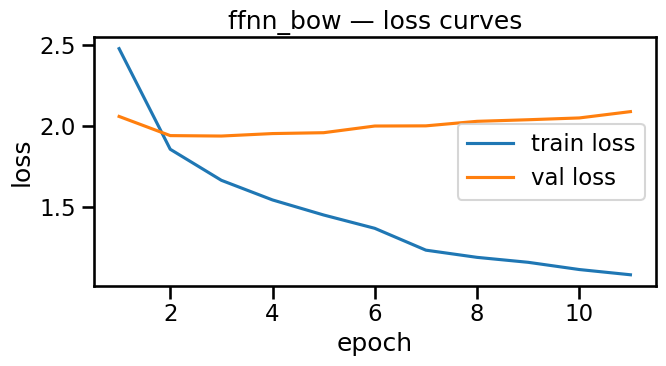

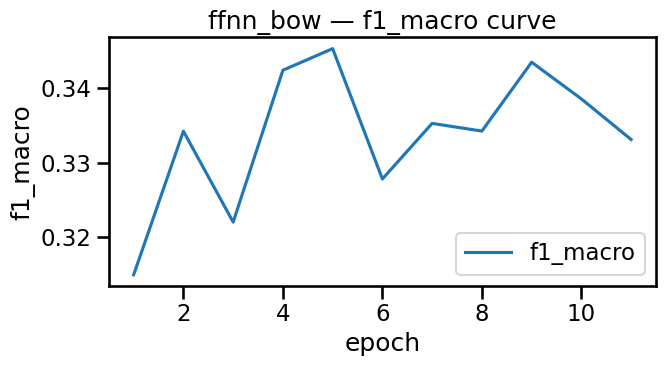

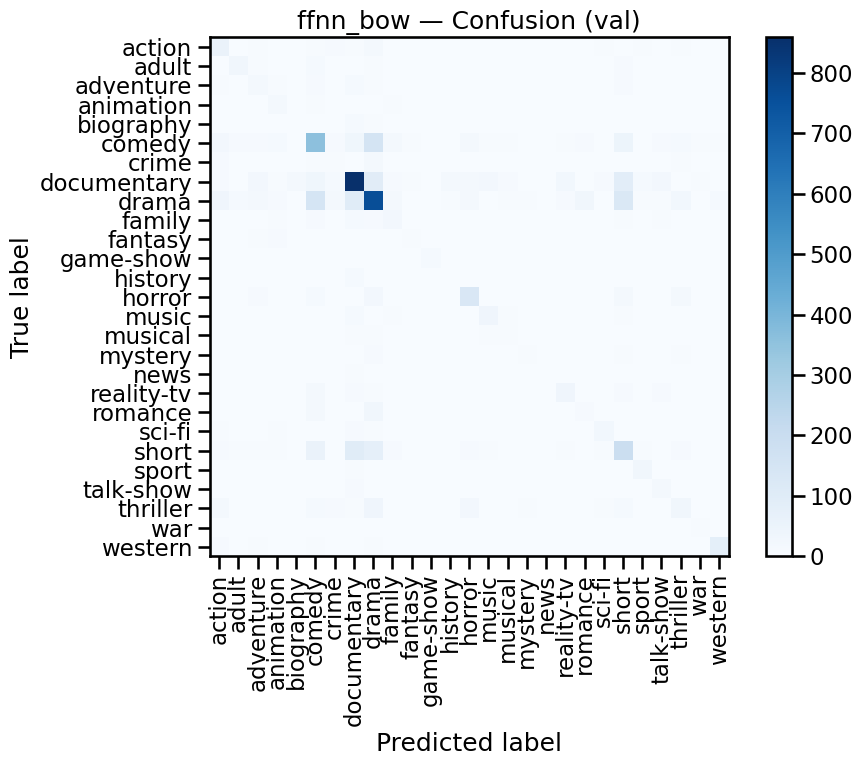

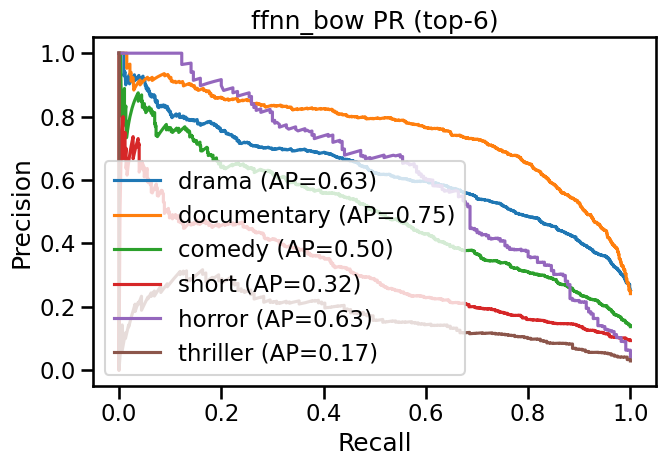

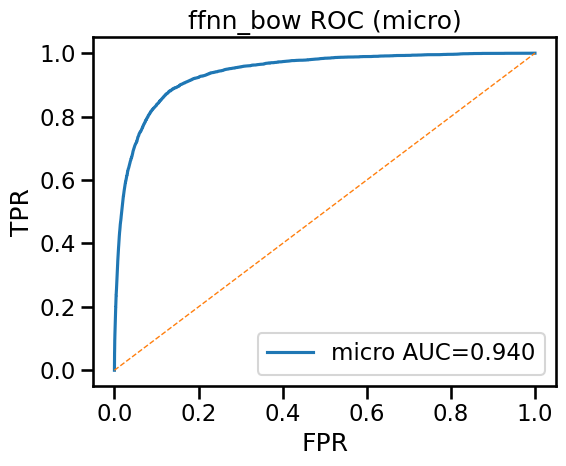

val: {'acc': 0.5052573325954621, 'prec_macro': 0.33636467418555555, 'recall_macro': 0.36565163939333656, 'f1_macro': 0.3453390529297722}


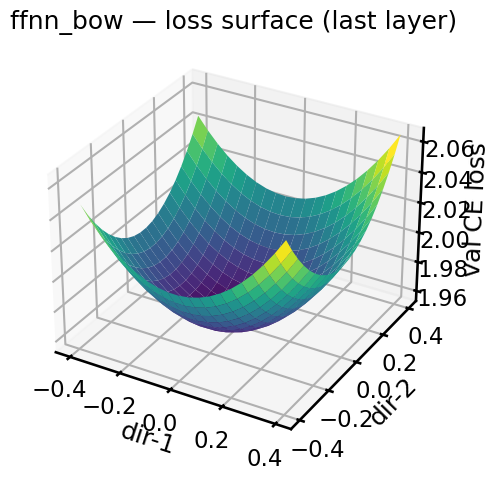


==== TFIDF ====
[ffnn_tfidf] ep01  loss=2.2908  vloss=1.8140  acc=0.5335  f1=0.3553
[ffnn_tfidf] ep02  loss=1.6424  vloss=1.7353  acc=0.5464  f1=0.3826
[ffnn_tfidf] ep03  loss=1.4547  vloss=1.7646  acc=0.5232  f1=0.3646
[ffnn_tfidf] ep04  loss=1.3218  vloss=1.7819  acc=0.5283  f1=0.3643
[ffnn_tfidf] ep05  loss=1.2200  vloss=1.8219  acc=0.5298  f1=0.3661
[ffnn_tfidf] ep06  loss=1.1240  vloss=1.8547  acc=0.5350  f1=0.3806
[ffnn_tfidf] ep07  loss=0.9812  vloss=1.8721  acc=0.5368  f1=0.3771
[ffnn_tfidf] ep08  loss=0.9276  vloss=1.9147  acc=0.5383  f1=0.3787
Early stopping.


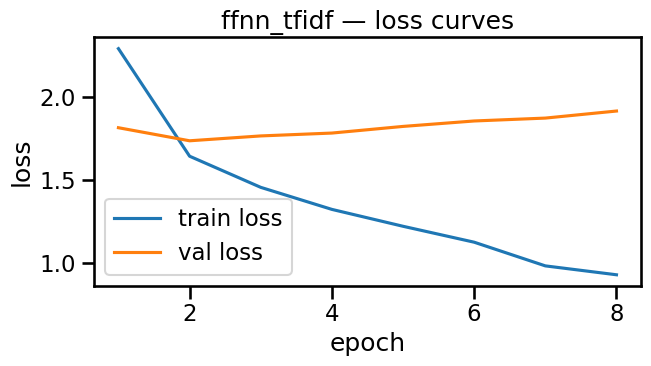

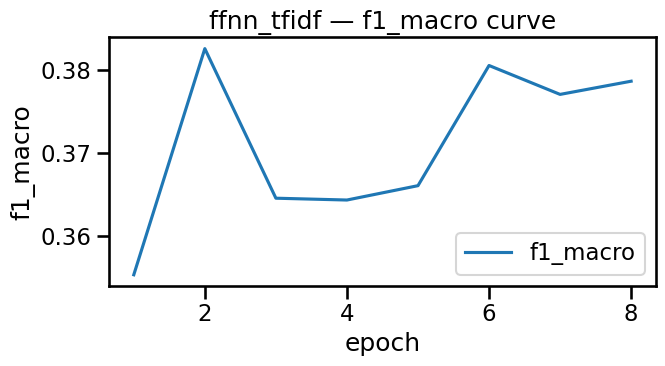

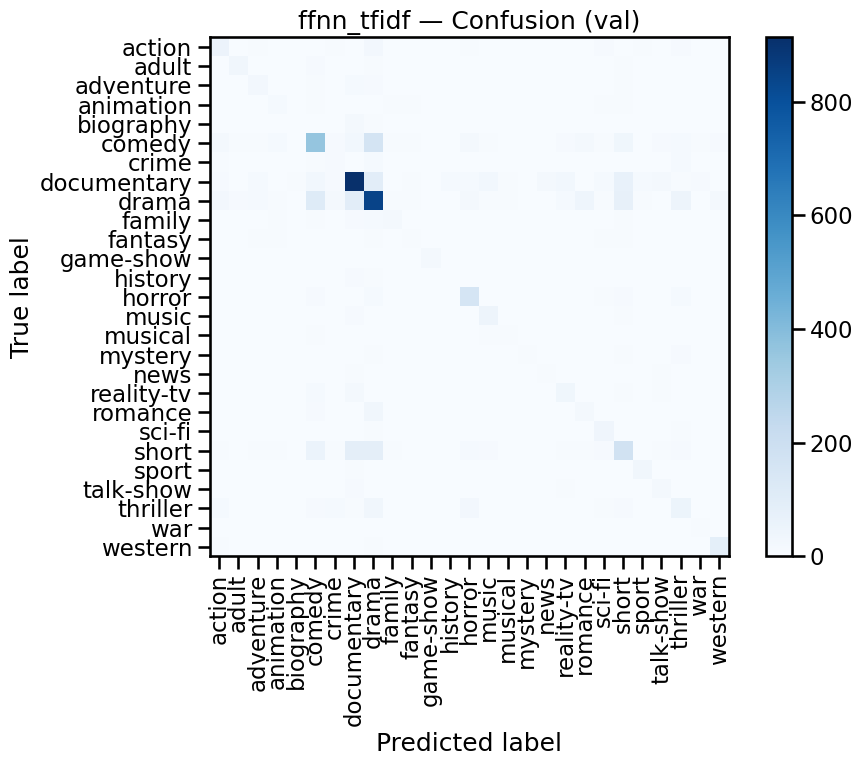

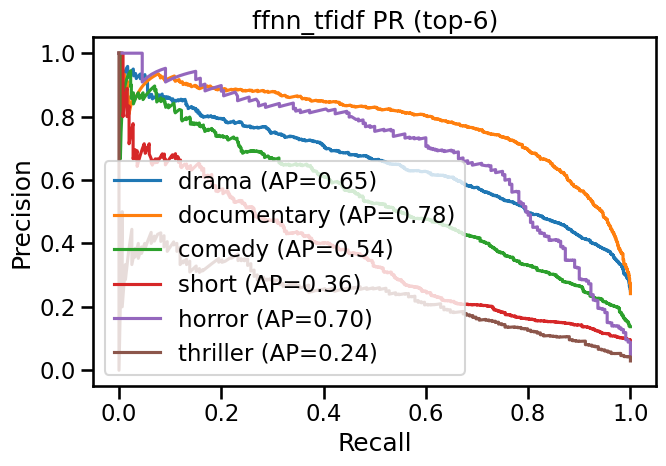

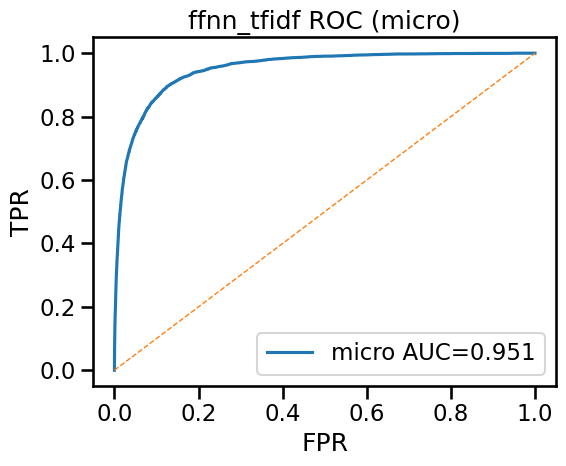

val: {'acc': 0.5463936543073233, 'prec_macro': 0.3708748575890434, 'recall_macro': 0.4136475821666496, 'f1_macro': 0.38261957518874773}


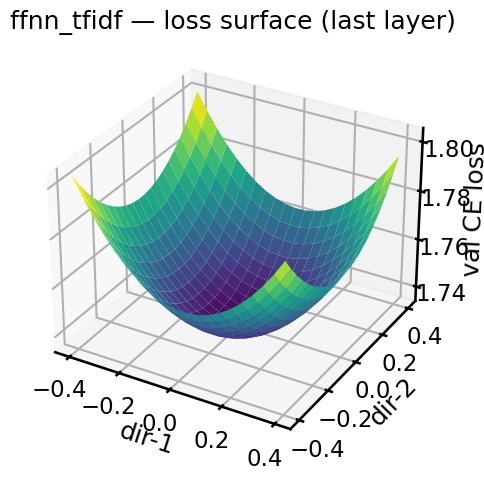


==== W2V ====
[ffnn_w2v] ep01  loss=2.2893  vloss=2.1394  acc=0.4630  f1=0.2333
[ffnn_w2v] ep02  loss=2.1148  vloss=2.0880  acc=0.4636  f1=0.2461
[ffnn_w2v] ep03  loss=2.0771  vloss=2.0738  acc=0.4566  f1=0.2538
[ffnn_w2v] ep04  loss=2.0491  vloss=2.0600  acc=0.4719  f1=0.2573
[ffnn_w2v] ep05  loss=2.0216  vloss=2.0582  acc=0.4737  f1=0.2701
[ffnn_w2v] ep06  loss=2.0073  vloss=2.0307  acc=0.4726  f1=0.2685
[ffnn_w2v] ep07  loss=1.9673  vloss=2.0208  acc=0.4837  f1=0.2770
[ffnn_w2v] ep08  loss=1.9578  vloss=2.0215  acc=0.4745  f1=0.2652
[ffnn_w2v] ep09  loss=1.9484  vloss=2.0193  acc=0.4737  f1=0.2756
[ffnn_w2v] ep10  loss=1.9455  vloss=2.0291  acc=0.4768  f1=0.2725
[ffnn_w2v] ep11  loss=1.9374  vloss=2.0240  acc=0.4761  f1=0.2740
[ffnn_w2v] ep12  loss=1.9270  vloss=2.0110  acc=0.4745  f1=0.2808
[ffnn_w2v] ep13  loss=1.9236  vloss=2.0174  acc=0.4772  f1=0.2783
[ffnn_w2v] ep14  loss=1.9116  vloss=2.0198  acc=0.4770  f1=0.2816
[ffnn_w2v] ep15  loss=1.9097  vloss=2.0180  acc=0.4842  f1=0.

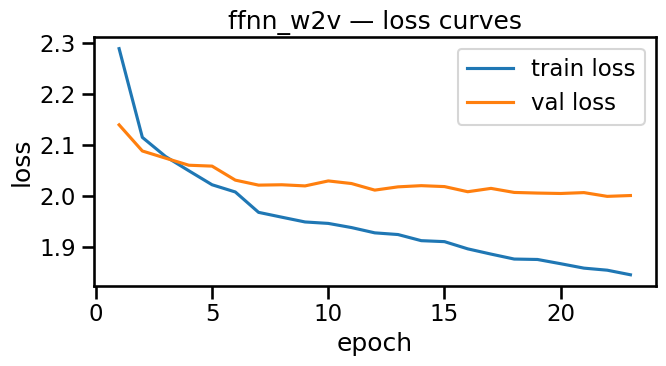

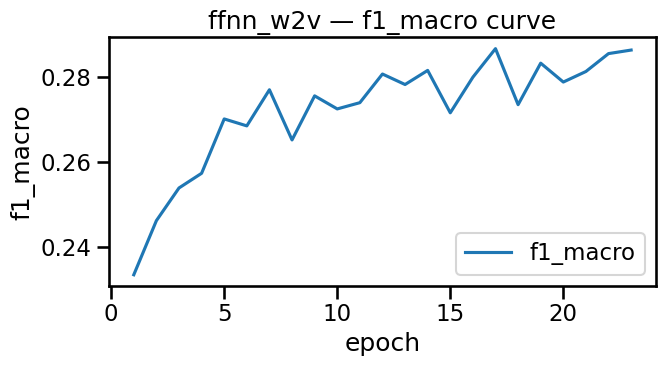

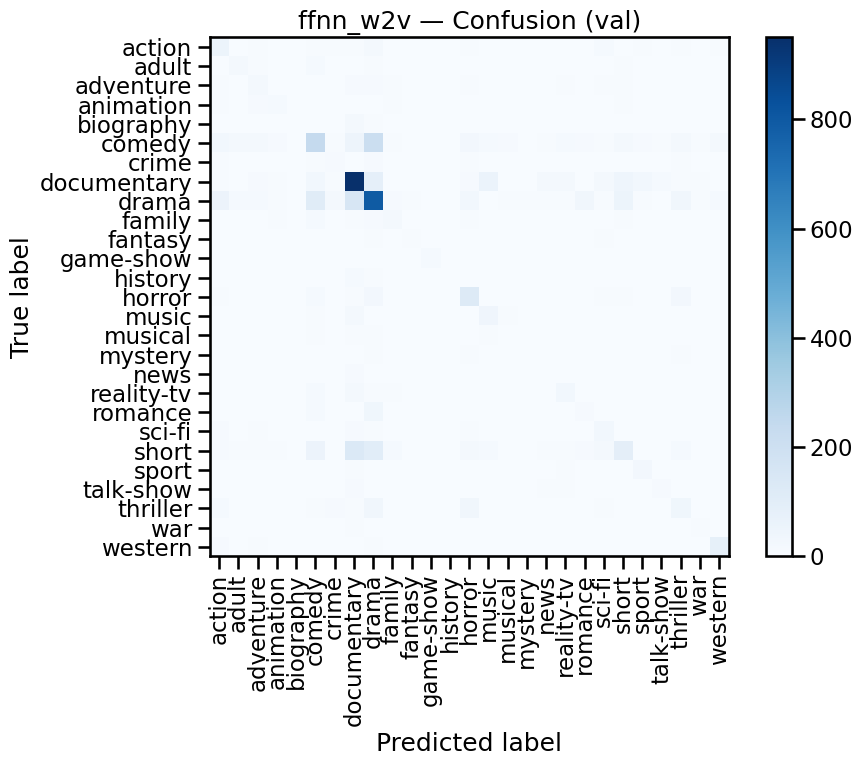

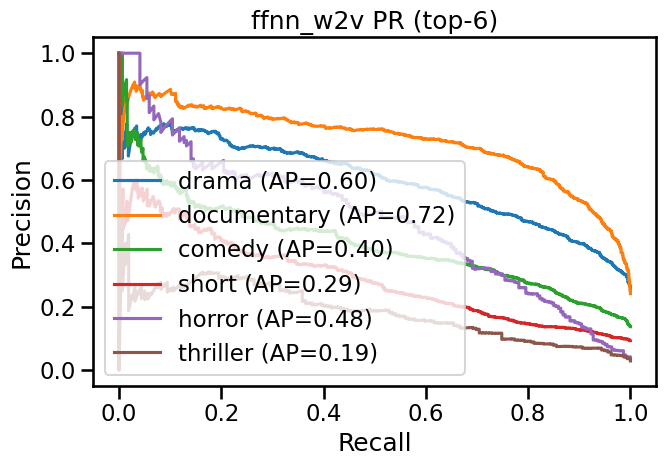

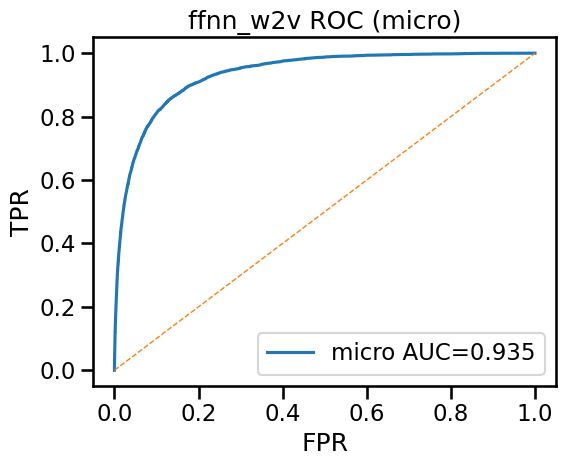

val: {'acc': 0.4799852425751706, 'prec_macro': 0.2745032026989827, 'recall_macro': 0.3212979229620982, 'f1_macro': 0.2867563463503966}


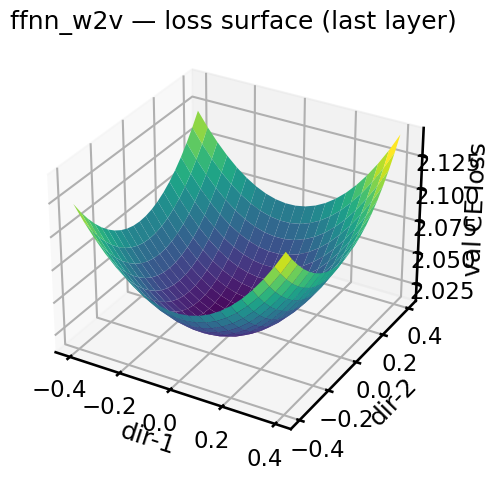


==== FASTTEXT ====
[ffnn_fasttext] ep01  loss=2.3336  vloss=2.1758  acc=0.4645  f1=0.2346
[ffnn_fasttext] ep02  loss=2.1761  vloss=2.1446  acc=0.4495  f1=0.2297
[ffnn_fasttext] ep03  loss=2.1337  vloss=2.1243  acc=0.4516  f1=0.2460
[ffnn_fasttext] ep04  loss=2.1087  vloss=2.1122  acc=0.4601  f1=0.2538
[ffnn_fasttext] ep05  loss=2.0896  vloss=2.0942  acc=0.4625  f1=0.2589
[ffnn_fasttext] ep06  loss=2.0708  vloss=2.0820  acc=0.4693  f1=0.2602
[ffnn_fasttext] ep07  loss=2.0341  vloss=2.0752  acc=0.4704  f1=0.2568
[ffnn_fasttext] ep08  loss=2.0278  vloss=2.0686  acc=0.4604  f1=0.2691
[ffnn_fasttext] ep09  loss=2.0233  vloss=2.0638  acc=0.4647  f1=0.2657
[ffnn_fasttext] ep10  loss=2.0149  vloss=2.0607  acc=0.4757  f1=0.2760
[ffnn_fasttext] ep11  loss=2.0090  vloss=2.0606  acc=0.4711  f1=0.2623
[ffnn_fasttext] ep12  loss=2.0020  vloss=2.0492  acc=0.4752  f1=0.2759
[ffnn_fasttext] ep13  loss=1.9950  vloss=2.0584  acc=0.4778  f1=0.2742
[ffnn_fasttext] ep14  loss=1.9906  vloss=2.0562  acc=0.46

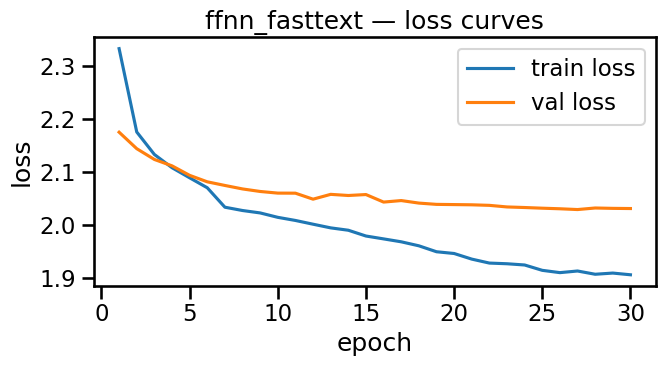

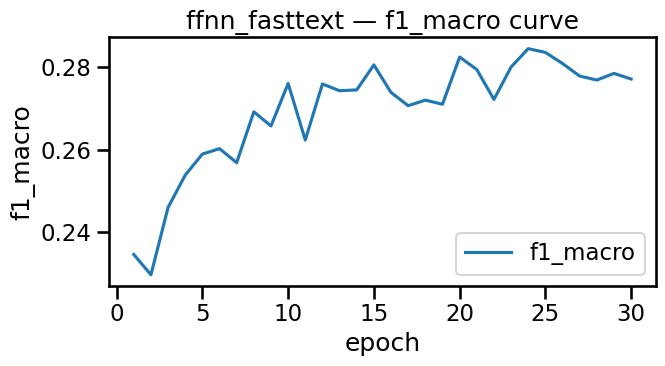

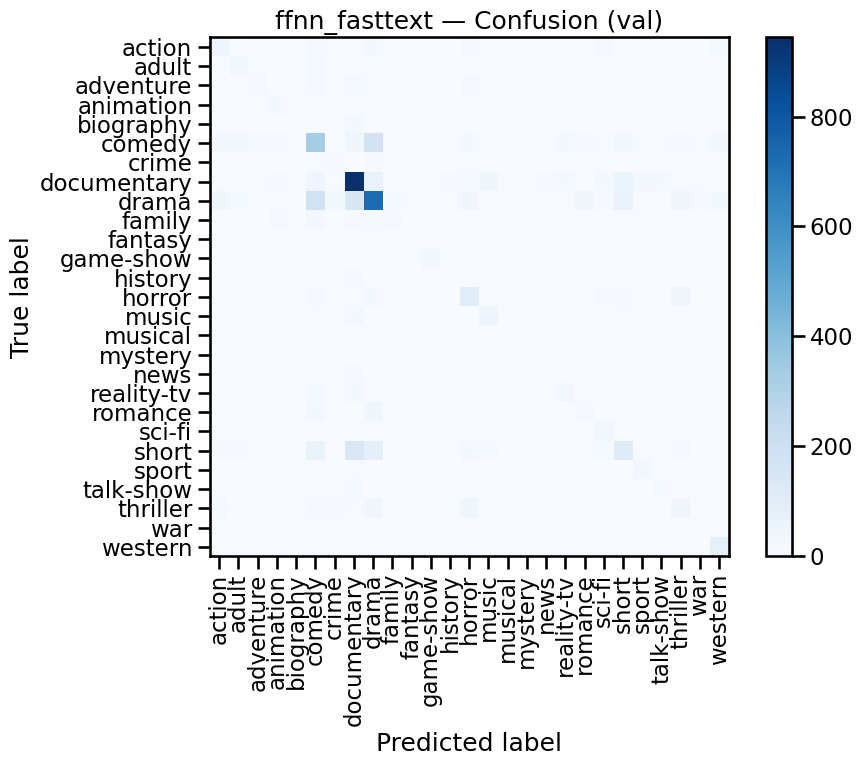

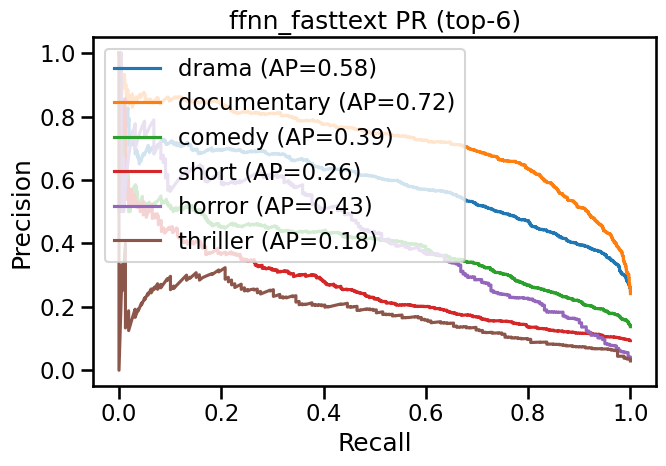

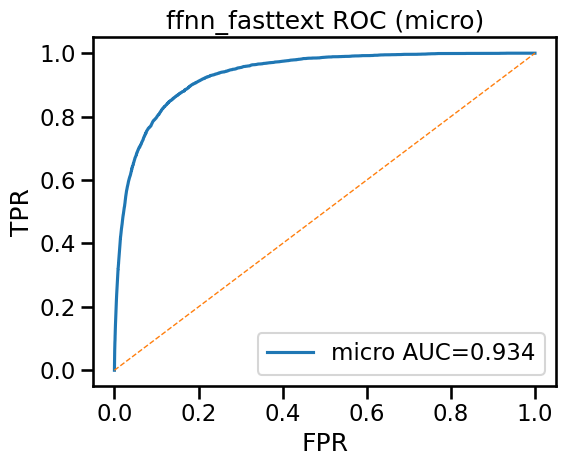

val: {'acc': 0.4803541781959048, 'prec_macro': 0.2685696828721568, 'recall_macro': 0.32162241104550565, 'f1_macro': 0.28440337886980344}


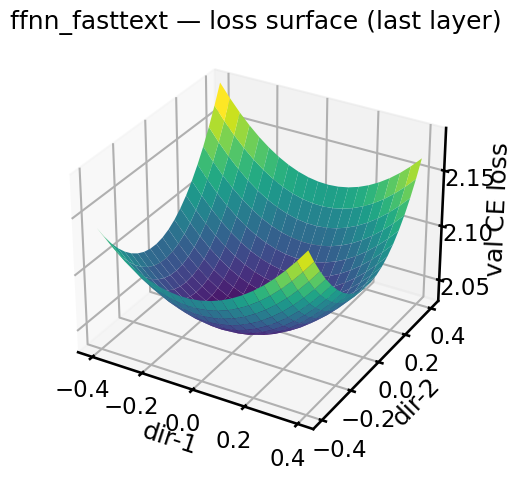


==== MINILM ====


encode all-MiniLM-L6-v2 bs=96: 100%|██████████| 57/57 [00:04<00:00, 12.78it/s]


[ffnn_minilm] ep01  loss=2.0293  vloss=1.7148  acc=0.5322  f1=0.3625
[ffnn_minilm] ep02  loss=1.6807  vloss=1.6815  acc=0.5374  f1=0.3777
[ffnn_minilm] ep03  loss=1.5771  vloss=1.6644  acc=0.5405  f1=0.3840
[ffnn_minilm] ep04  loss=1.4943  vloss=1.6762  acc=0.5398  f1=0.3890
[ffnn_minilm] ep05  loss=1.4327  vloss=1.6847  acc=0.5368  f1=0.3846
[ffnn_minilm] ep06  loss=1.3649  vloss=1.6970  acc=0.5294  f1=0.3739
[ffnn_minilm] ep07  loss=1.2615  vloss=1.7039  acc=0.5327  f1=0.3831
[ffnn_minilm] ep08  loss=1.2251  vloss=1.7172  acc=0.5230  f1=0.3821
[ffnn_minilm] ep09  loss=1.1985  vloss=1.7338  acc=0.5344  f1=0.3875
[ffnn_minilm] ep10  loss=1.1666  vloss=1.7397  acc=0.5344  f1=0.3846
Early stopping.


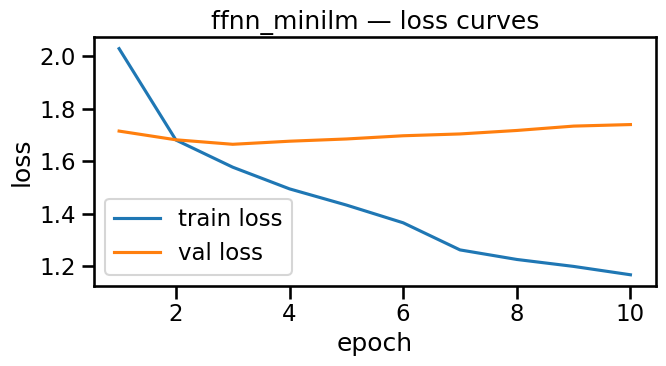

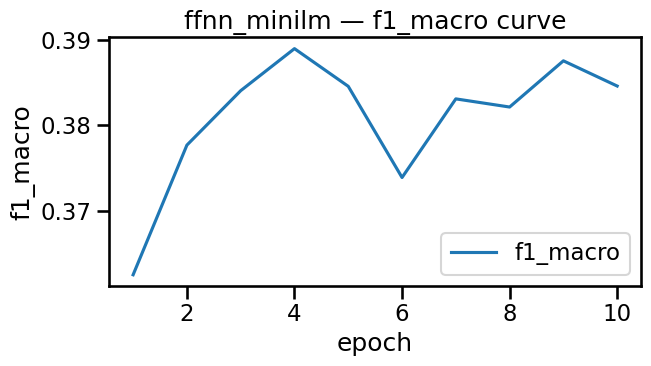

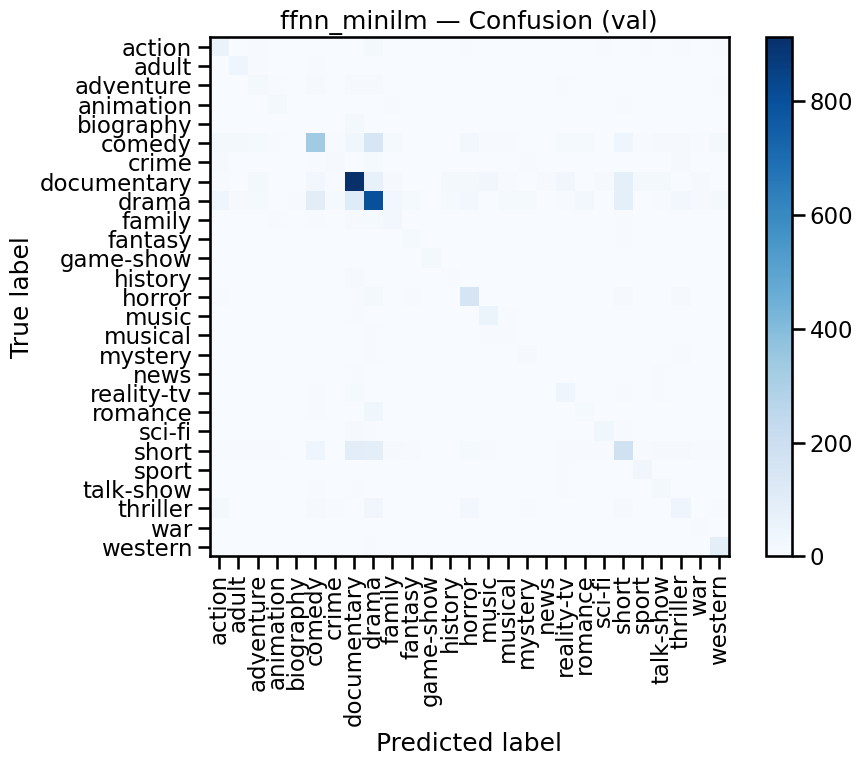

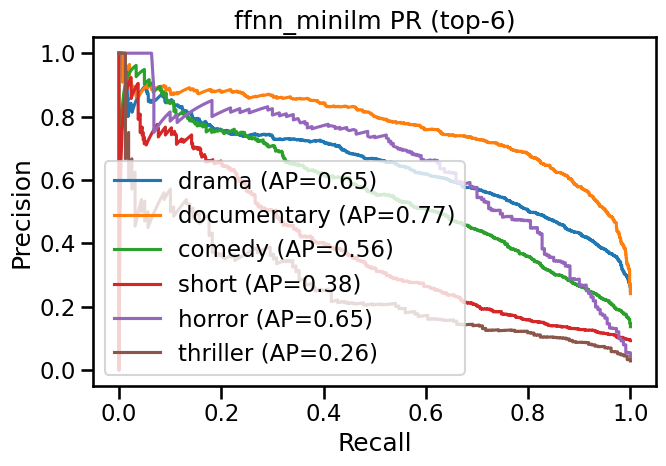

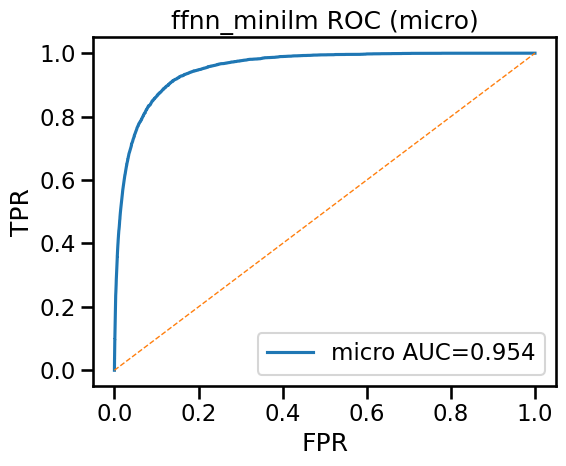

val: {'acc': 0.5397528131341081, 'prec_macro': 0.36750234659256614, 'recall_macro': 0.4373786917965446, 'f1_macro': 0.38897472760238366}


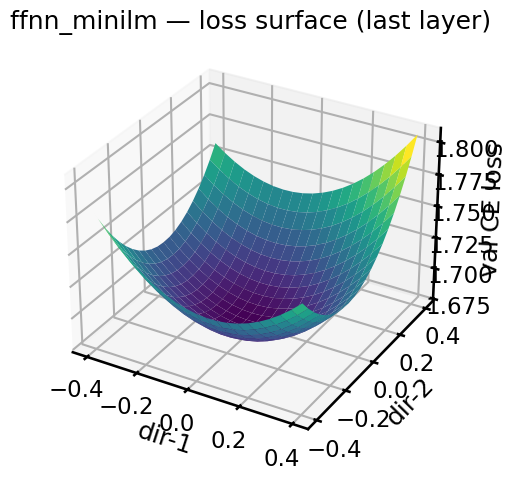

name  dim  svd_components  explained_var_ratio_sum  scaled  \
4  all-MiniLM-L6-v2  384             NaN                      NaN    True   
1             tfidf  512           512.0                 0.127105    True   
0               bow  512           512.0                 0.436975    True   
2               w2v  200             NaN                      NaN    True   
3          fasttext  200             NaN                      NaN    True   

       type     vocab       acc  prec_macro  recall_macro  f1_macro   ngram  \
4        st       NaN  0.539753    0.367502      0.437379  0.388975     NaN   
1     tfidf  200000.0  0.546394    0.370875      0.413648  0.382620  (1, 2)   
0       bow   42952.0  0.505257    0.336365      0.365652  0.345339     NaN   
2       w2v       NaN  0.479985    0.274503      0.321298  0.286756     NaN   
3  fasttext       NaN  0.480354    0.268570      0.321622  0.284403     NaN   

   window  min_count  max_len  batch_size  
4     NaN        NaN    160.0        96.0  
1     NaN        NaN      NaN         NaN  
0     NaN        NaN      NaN         NaN  
2     5.0        3.0      NaN         NaN  
3     5.0        3.0      NaN         NaN

In [65]:
# Benchmark run 

NUM_CLASSES = len(le.classes_)
labels = [id2label[i] for i in range(NUM_CLASSES)]

# class weights (balanced)

ytr = train_df["label"].values
yva = val_df["label"].values
classes = np.unique(ytr)
cw_raw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
cls_w = (cw_raw ** 0.5).astype("float32")

EMBS = [
    ("bow",      lambda tr,va: build_bow(tr, va, max_features=200_000, min_df=2, svd_components=512)),
    ("tfidf",    lambda tr,va: build_tfidf(tr, va, max_features=200_000, ngram_range=(1,2), min_df=2, svd_components=512)),
    ("w2v",      lambda tr,va: build_w2v(tr, va, dim=200, window=5, min_count=3)),
    ("fasttext", lambda tr,va: build_fasttext(tr, va, dim=200, window=5, min_count=3)),
    ("minilm",   lambda tr,va: build_minilm(tr, va, model_name="all-MiniLM-L6-v2", batch_size=96, max_length=160)),
]

results = []
for name, builder in EMBS:
    print(f"\n==== {name.upper()} ====")
    classic = name in {"bow","tfidf","w2v","fasttext"}
    tr_texts = train_df["classic_text"] if classic else train_df["neural_text"]
    va_texts = val_df["classic_text"]   if classic else val_df["neural_text"]

    Xtr, Xva, dim, info = builder(tr_texts, va_texts)

    run_name = f"ffnn_{name}"
    tracker = MetricTracker(run_name, main_metric="f1_macro", log_to_mlflow=False)
    out = train_ffnn_multiclass(
        Xtr, ytr, Xva, yva,
        hidden_dim=256, dropout=0.2,
        lr=1e-3, epochs=60, batch_size=128, patience=6,
        class_weights=cls_w,
        run_name=run_name,
        tracker=tracker
    )
    print("val:", out["val_metrics"])

    try:
        if dim <= 1024:
            Xva_t = torch.tensor(np.asarray(Xva, dtype=np.float32))
            yva_t = torch.tensor(yva, dtype=torch.long)
            va_dl = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=256, shuffle=False, pin_memory=True)
            crit = nn.CrossEntropyLoss(weight=torch.tensor(cls_w, dtype=torch.float32, device=("cuda" if torch.cuda.is_available() else "cpu")))
            surf_path = REPORTS_DIR/f"{run_name}_loss_surface.png"
            _ = plot_loss_surface_last_layer(
                model=out["model"], va_dl=va_dl, crit=crit,
                steps=21, scale=0.4, max_val_batches=30,
                title=f"{run_name} — loss surface (last layer)",
                save_path=surf_path,
                as_3d=True
            )
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("[loss-surface] OOM → пропускаем визуализацию для", name)
            torch.cuda.empty_cache()

    # MLflow summary
    log_run(
        model_name=run_name,
        params={"emb": name, "dim": dim, **info, "hidden":256, "dropout":0.2, "epochs":60, "bs":128, "lr":1e-3},
        metrics=out["val_metrics"],
        artifacts=out["artifacts"],
        tags={"phase":"ffnn_embeddings"}
    )

    results.append({"name": name, "dim": dim, **info, **out["val_metrics"]})
    del Xtr, Xva
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

df_res = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
display(df_res)
df_res.to_csv(REPORTS_DIR/"ffnn_embeddings_benchmark.csv", index=False)

## Промежуточные выводы (classic embeddings → FFNN)
### Что запустили

Один и тот же FFNN (BatchNorm, Dropout, AdamW, Cosine, AMP), class weights смягчены cw**0.5.
Разреженные (BoW/TF-IDF): TruncatedSVD(512) → z-score; плотные (W2V/FT/MiniLM): z-score.
Валидация: 27 классов, macro-F1.

### Итоги 

MiniLM (all-MiniLM-L6-v2) — acc 0.540, macro-F1 0.389

TF-IDF + SVD(512) — acc 0.546, macro-F1 0.383

BoW + SVD(512) — acc 0.505, macro-F1 0.345

Word2Vec (avg, 200d) — acc 0.480, macro-F1 0.287

FastText (avg, 200d) — acc 0.480, macro-F1 0.284

### Наблюдения

TF-IDF ≈ MiniLM при фиксированной FFNN-голове: разрыв по macro-F1 минимальный → узкое место сейчас в самой голове/классификаторе, а не в эмбеддингах.

BoW < TF-IDF (ожидаемо): биграммы и IDF лучше кодируют жанровые триггеры.

W2V/FT (avg pooling) заметно слабее: усреднение теряет порядок/ключевые конструкции.

z-score + BN + cw**0.5 удерживают precision/recall в разумном балансе; имбаланс хвоста по-прежнему ограничивает macro-F1.

### Почему так

Жанры часто держатся на редких n-граммах и коллокациях, что «нативно» подхватывает TF-IDF (+LSA). Sentence-эмбеддинги без fine-tune не получают значительного преимущества, если сверху простая FFNN-голова.

TF-IDF SVD 768/1024 (часто +0.5–1.5 pp macro-F1).

TF-IDF-взвешенное усреднение для W2V/FT или SIF — дешёвая проверка, иногда +1–2 pp к avg.

### Вывод

TF-IDF+SVD — надёжный и дешёвый baseline, практически на уровне MiniLM+FFNN.

Смысл дальше — RNN → лёгкие трансформеры с fine-tune: там реалистично ещё +3–8 pp macro-F1.

## RNN

In [50]:
# RNN: vocab & encoding

PAD, UNK = 0, 1

def build_vocab(texts, min_freq=2, max_vocab=60000):
    cnt = Counter()
    for s in texts:
        cnt.update(str(s).split())
    # частотная отсечка
    toks = [w for w,f in cnt.items() if f >= min_freq]
    toks.sort(key=lambda w: (-cnt[w], w))
    toks = toks[:max_vocab-2]
    stoi = {w:i+2 for i,w in enumerate(toks)}
    stoi["<PAD>"] = PAD; stoi["<UNK>"] = UNK
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, cnt

stoi, itos, cnt = build_vocab(train_df["classic_text"], min_freq=2, max_vocab=60000)
vocab_size = len(stoi); print("vocab_size:", vocab_size)

def encode_text(s, stoi):
    ids = []
    for w in str(s).split():
        ids.append(stoi.get(w, UNK))
    return np.array(ids, dtype=np.int32)

# длины по classic_text (после пайплайна)
lens = train_df["classic_text"].str.split().apply(len)
q95 = int(np.percentile(lens, 95))
max_len = min(192, max(64, q95))  # разумный клип под VRAM
print("RNN max_len:", max_len)

# кодируем
tr_ids = [encode_text(s, stoi) for s in train_df["classic_text"]]
va_ids = [encode_text(s, stoi) for s in val_df["classic_text"]]
ho_ids = [encode_text(s, stoi) for s in hold_df["classic_text"]]
ytr = train_df["label"].values.astype(np.int64)
yva = val_df["label"].values.astype(np.int64)
yho = hold_df["label"].values.astype(np.int64)

vocab_size: 52429
RNN max_len: 115


In [59]:
# RNN: dataset & collate

class TxtDS(Dataset):
    def __init__(self, seqs, ys):
        self.seqs = seqs; self.ys = ys
    def __len__(self): return len(self.seqs)
    def __getitem__(self, i): return self.seqs[i], self.ys[i]

def collate_pad(batch, max_len=max_len):
    # используем pack_padded_sequence с lengths
    xs, ys = zip(*batch)
    lens = [min(len(x), max_len) for x in xs]
    # обрезка + паддинг
    X = torch.full((len(xs), max_len), PAD, dtype=torch.long)
    for i, (arr, L) in enumerate(zip(xs, lens)):
        if L>0: X[i, :L] = torch.tensor(arr[:L], dtype=torch.long)
    return X, torch.tensor(lens, dtype=torch.long), torch.tensor(ys, dtype=torch.long)

tr_ds = TxtDS(tr_ids, ytr)
va_ds = TxtDS(va_ids, yva)
ho_ds = TxtDS(ho_ids, yho)

BATCH = 128
tr_dl = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  pin_memory=True, collate_fn=collate_pad)
va_dl = DataLoader(va_ds, batch_size=BATCH*2, shuffle=False, pin_memory=True, collate_fn=collate_pad)
ho_dl = DataLoader(ho_ds, batch_size=BATCH*2, shuffle=False, pin_memory=True, collate_fn=collate_pad)

In [60]:
def train_gensim(kind="w2v", dim=200, window=5, min_count=2):
    tok = [s.split() for s in train_df["classic_text"]]
    if kind == "w2v":
        m = Word2Vec(sentences=tok, vector_size=dim, window=window, min_count=min_count, workers=4, seed=SEED)
    else:
        m = FastText(sentences=tok,   vector_size=dim, window=window, min_count=min_count, workers=4, seed=SEED)
    return m

def make_embedding_matrix(stoi, keyed_vectors, dim):
    W = np.zeros((len(stoi), dim), dtype=np.float32)
    miss = 0
    for w,i in stoi.items():
        if i in (PAD, UNK): 
            continue
        if w in keyed_vectors:
            W[i] = keyed_vectors[w]
        else:
            miss += 1
    cov = 1 - miss / max(1, (len(stoi)-2))
    return W, cov

In [61]:
# RNN: model 

class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, num_classes, cell="gru",
                 dropout=0.3, pad_idx=PAD, num_layers=1, pretrained_W=None, freeze_emb=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if pretrained_W is not None:
            self.emb.weight.data.copy_(torch.tensor(pretrained_W))
        self.emb.weight.requires_grad = not freeze_emb
        rnn_cls = nn.GRU if cell=="gru" else nn.LSTM
        self.rnn = rnn_cls(input_size=emb_dim, hidden_size=hidden, num_layers=num_layers,
                           batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        # читаем из пула (2H → fc)
        self.fc = nn.Linear(hidden*2*2, num_classes)  # mean + max

    def forward(self, x, lens):
        emb = self.emb(x)  # [B,T,E]
        packed = pack_padded_sequence(emb, lens.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(packed)                      # out: PackedSequence
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.size(1))  # [B,T,2H]

        # маска для паддинга
        mask = (torch.arange(x.size(1), device=x.device)[None,:] < lens[:,None]).float()  # [B,T]
        mask = mask.unsqueeze(-1)  # [B,T,1]

        out = out * mask  # зануляем паддинг

        # mean pooling (по реальной длине)
        sum_pool = out.sum(dim=1)                          # [B,2H]
        len_clamped = lens.clamp(min=1).unsqueeze(1).float()
        mean_pool = sum_pool / len_clamped

        # max pooling (по реальной длине)
        # заменим паддинги -inf, чтобы max их игнорировал
        out_masked = out + (1.0 - mask) * (-1e9)
        max_pool, _ = out_masked.max(dim=1)               # [B,2H]

        feat = torch.cat([mean_pool, max_pool], dim=1)    # [B,4H]
        logits = self.fc(self.dropout(feat))
        return logits

In [62]:
# RNN: train/eval 

def run_rnn(
    cell="gru", emb_dim=200, hidden=256, num_layers=1, dropout=0.3,
    use_pretrained=None,   # None | "w2v" | "fasttext"
    freeze_emb=False,
    alpha=0.5,             # class weights exponent (cw**alpha)
    max_epochs=40, patience=6, lr=2e-3, grad_clip=1.0,
    run_name="rnn_gru"
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # class weights
    from sklearn.utils.class_weight import compute_class_weight
    cw_base = compute_class_weight(class_weight="balanced", classes=np.arange(len(le.classes_)), y=ytr)
    cls_w = (cw_base ** alpha).astype("float32")
    crit = nn.CrossEntropyLoss(weight=torch.tensor(cls_w, dtype=torch.float32, device=device))

    # pretrained W
    W = None; cov=None
    if use_pretrained in {"w2v","fasttext"}:
        gm = train_gensim(kind=use_pretrained, dim=emb_dim, window=5, min_count=2)
        W, cov = make_embedding_matrix(stoi, gm.wv, emb_dim)
        print(f"Pretrained={use_pretrained} | coverage={cov:.1%}")

    model = BiRNNClassifier(
        vocab_size=len(stoi), emb_dim=emb_dim, hidden=hidden, num_classes=len(le.classes_),
        cell=cell, dropout=dropout, num_layers=num_layers,
        pretrained_W=W, freeze_emb=freeze_emb
    ).to(device)

    opt  = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=1e-3, weight_decay=1e-2)
    sched= torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(10,max_epochs//2))
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    tracker = MetricTracker(run_name, main_metric="f1_macro")
    best = {"f1": -1.0, "state": None, "acc":0, "prec":0, "rec":0, "logits":None, "y":None, "pred":None}
    bad = 0

    for ep in range(1, max_epochs+1):
        model.train(); tr_loss=0.0
        for xb, lens, yb in tr_dl:
            xb, lens, yb = xb.to(device), lens.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(xb, lens)
                loss = crit(logits, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt); scaler.update()
            tr_loss += float(loss) * xb.size(0)
        tr_loss /= len(tr_ds)
        sched.step()

        # val
        model.eval(); va_loss=0.0; Ys=[]; Ps=[]; Ls=[]
        with torch.no_grad():
            for xb, lens, yb in va_dl:
                xb, lens, yb = xb.to(device), lens.to(device), yb.to(device)
                with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                    lg = model(xb, lens)
                    loss = crit(lg, yb)
                va_loss += float(loss) * xb.size(0)
                Ys.append(yb.cpu().numpy()); Ps.append(lg.detach().cpu().numpy())
                Ls.append(lg.argmax(1).cpu().numpy())
        va_loss /= len(va_ds)
        Y = np.concatenate(Ys); LOG = np.concatenate(Ps); PRED = np.concatenate(Ls)
        acc = accuracy_score(Y, PRED)
        prec, rec, f1, _ = precision_recall_fscore_support(Y, PRED, average="macro", zero_division=0)

        tracker.log_epoch(ep, train_loss=tr_loss, val_loss=va_loss, acc=acc, f1_macro=f1)
        print(f"[{run_name}] ep{ep:02d}  tl={tr_loss:.4f}  vl={va_loss:.4f}  acc={acc:.4f}  f1={f1:.4f}")

        if f1 > best["f1"] + 1e-5:
            best.update({"f1":f1,"state":{k:v.detach().cpu() for k,v in model.state_dict().items()},
                         "acc":acc,"prec":prec,"rec":rec,"logits":LOG.copy(),"y":Y.copy(),"pred":PRED.copy()})
            bad=0
        else:
            bad+=1
            if bad>=patience:
                print("Early stopping."); break

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    arts = tracker.save_curves()
    cm_path = log_confusion_matrix(best["y"], best["pred"], le.classes_,
                                   title=f"{run_name} — Confusion (val)",
                                   filename=f"{run_name}_cm_val.png")
    pr_path = log_pr_curves(best["y"], best["logits"], le.classes_, top_k=6, title_prefix=run_name)
    roc_path= log_roc_micro(best["y"], best["logits"], le.classes_, title_prefix=run_name)
    arts.update({"cm":cm_path, "pr":pr_path, "roc":roc_path})
    # MLflow
    log_run(run_name,
            params={"cell":cell,"emb_dim":emb_dim,"hidden":hidden,"layers":num_layers,"dropout":dropout,
                    "pretrained":use_pretrained or "none","freeze_emb":freeze_emb,"alpha":alpha,"max_len":max_len},
            metrics={"acc":best["acc"],"f1_macro":best["f1"],"prec_macro":best["prec"],"recall_macro":best["rec"]},
            artifacts=arts, tags={"phase":"rnn"})

    # сохранить модель
    torch.save(model.state_dict(), ART/"models"/f"{run_name}_best.pt")
    return {"model": model, "best": best, "artifacts": arts}

[rnn_bigru_base] ep01  tl=2.8855  vl=2.6160  acc=0.4042  f1=0.1166
[rnn_bigru_base] ep02  tl=2.4242  vl=2.3110  acc=0.4365  f1=0.2101
[rnn_bigru_base] ep03  tl=2.1051  vl=2.1523  acc=0.4638  f1=0.2546
[rnn_bigru_base] ep04  tl=1.8644  vl=2.0411  acc=0.4763  f1=0.2889
[rnn_bigru_base] ep05  tl=1.6556  vl=2.0093  acc=0.4995  f1=0.3089
[rnn_bigru_base] ep06  tl=1.4620  vl=1.9807  acc=0.5104  f1=0.3265
[rnn_bigru_base] ep07  tl=1.2288  vl=2.0410  acc=0.4848  f1=0.3158
[rnn_bigru_base] ep08  tl=1.1158  vl=2.0862  acc=0.5056  f1=0.3253
[rnn_bigru_base] ep09  tl=1.0175  vl=2.1459  acc=0.5021  f1=0.3165
[rnn_bigru_base] ep10  tl=0.9229  vl=2.2288  acc=0.4787  f1=0.3146
[rnn_bigru_base] ep11  tl=0.8386  vl=2.3206  acc=0.4907  f1=0.3176
[rnn_bigru_base] ep12  tl=0.7542  vl=2.3832  acc=0.4979  f1=0.3149
Early stopping.


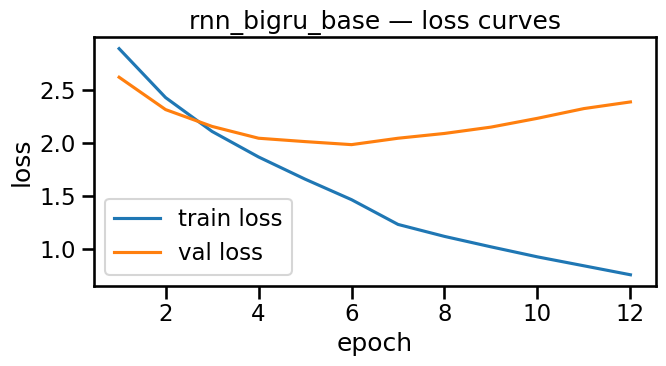

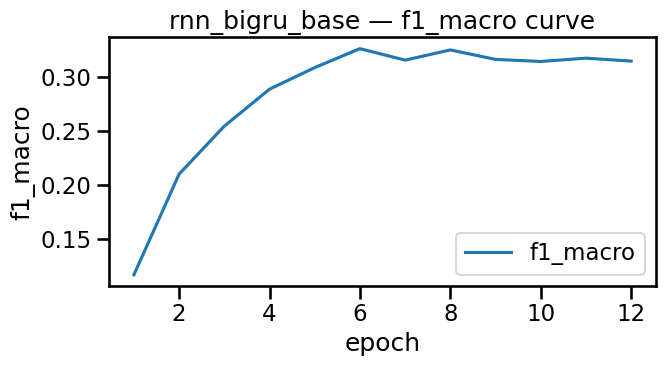

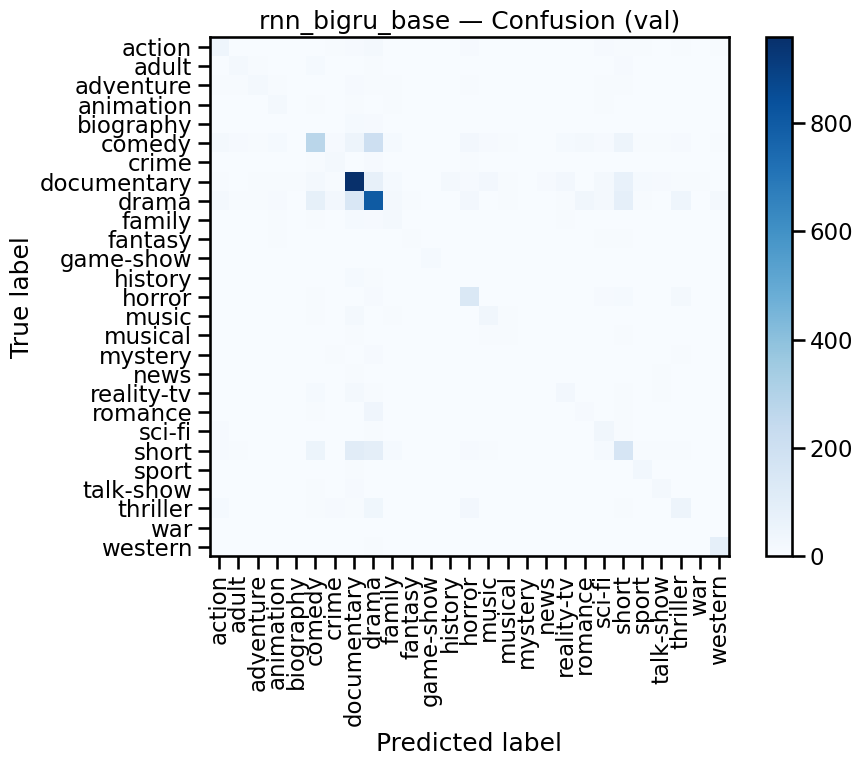

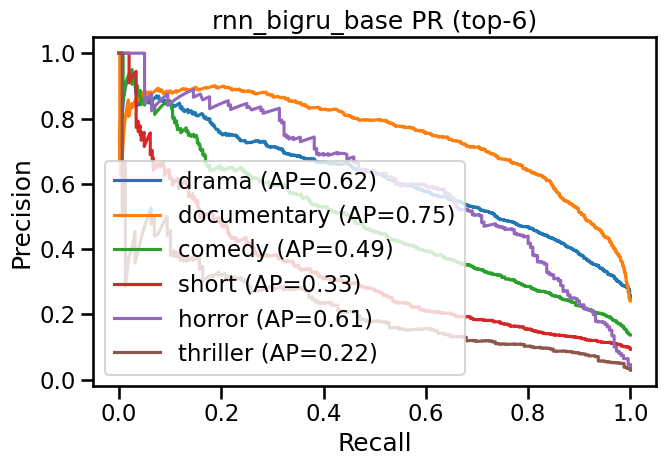

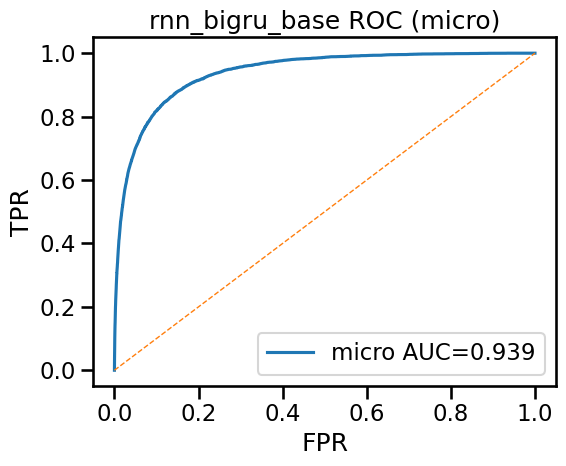

Pretrained=w2v | coverage=100.0%
[rnn_bigru_w2v_trainable_pooling] ep01  tl=2.4147  vl=2.2031  acc=0.4566  f1=0.2115
[rnn_bigru_w2v_trainable_pooling] ep02  tl=2.1466  vl=2.0632  acc=0.4636  f1=0.2477
[rnn_bigru_w2v_trainable_pooling] ep03  tl=2.0513  vl=2.0481  acc=0.4647  f1=0.2796
[rnn_bigru_w2v_trainable_pooling] ep04  tl=1.9807  vl=1.9644  acc=0.5043  f1=0.3095
[rnn_bigru_w2v_trainable_pooling] ep05  tl=1.9044  vl=1.9403  acc=0.5126  f1=0.3005
[rnn_bigru_w2v_trainable_pooling] ep06  tl=1.8429  vl=1.8794  acc=0.5018  f1=0.3081
[rnn_bigru_w2v_trainable_pooling] ep07  tl=1.7612  vl=1.8582  acc=0.5093  f1=0.3146
[rnn_bigru_w2v_trainable_pooling] ep08  tl=1.7275  vl=1.8501  acc=0.5148  f1=0.3330
[rnn_bigru_w2v_trainable_pooling] ep09  tl=1.6910  vl=1.8146  acc=0.5174  f1=0.3345
[rnn_bigru_w2v_trainable_pooling] ep10  tl=1.6623  vl=1.8068  acc=0.5353  f1=0.3346
[rnn_bigru_w2v_trainable_pooling] ep11  tl=1.6257  vl=1.8002  acc=0.5340  f1=0.3430
[rnn_bigru_w2v_trainable_pooling] ep12  tl=

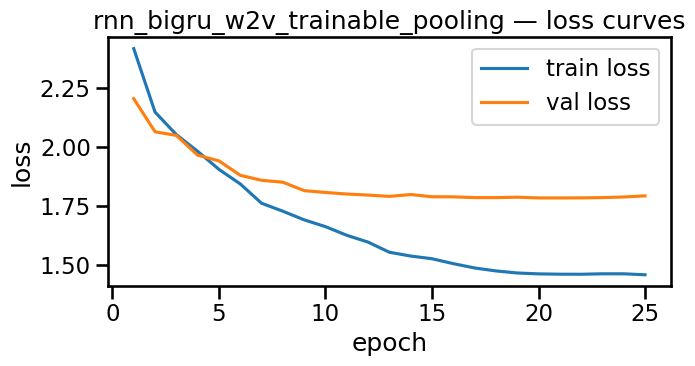

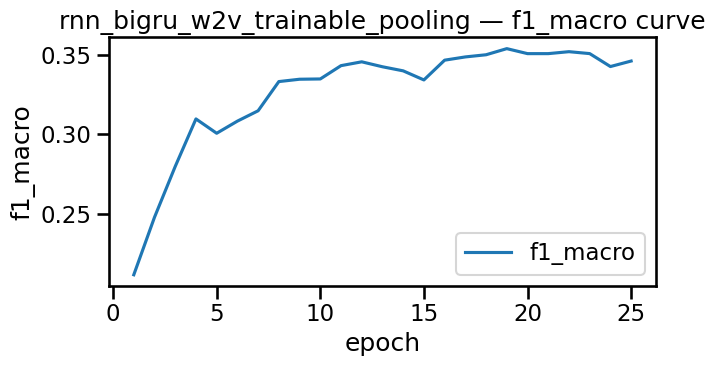

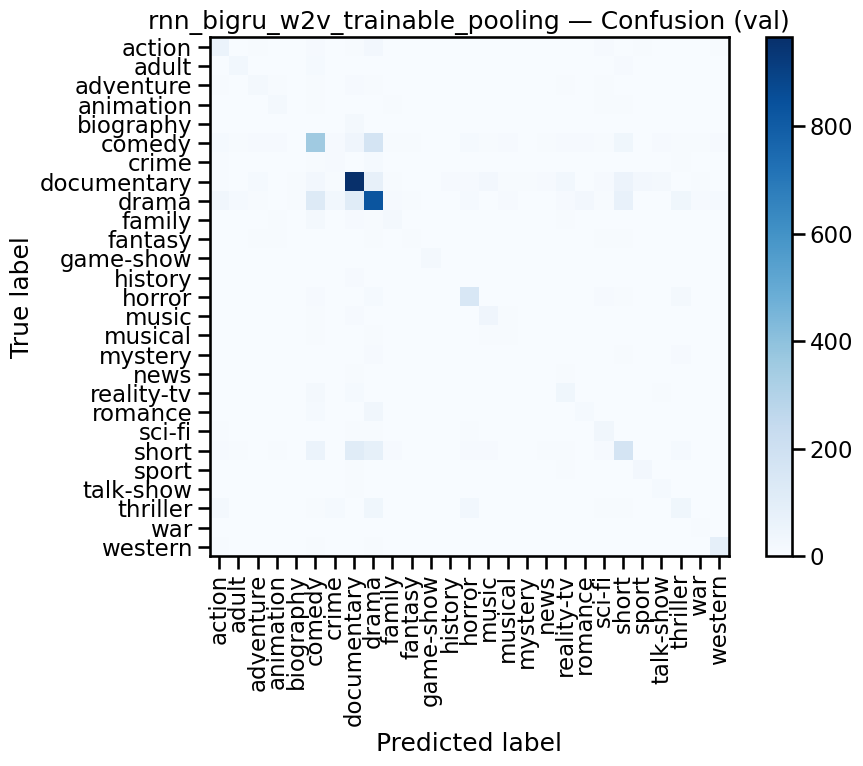

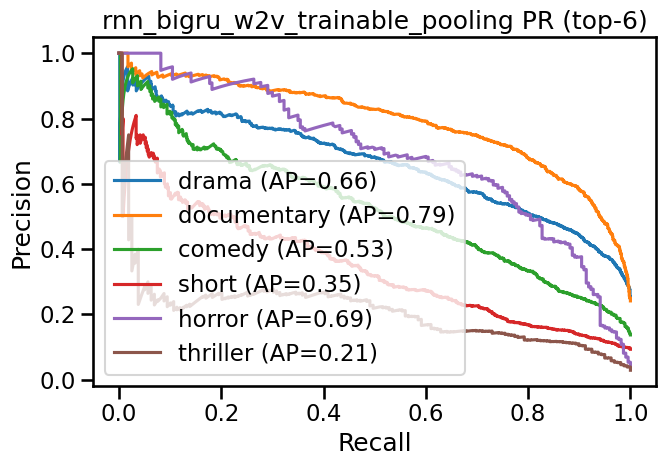

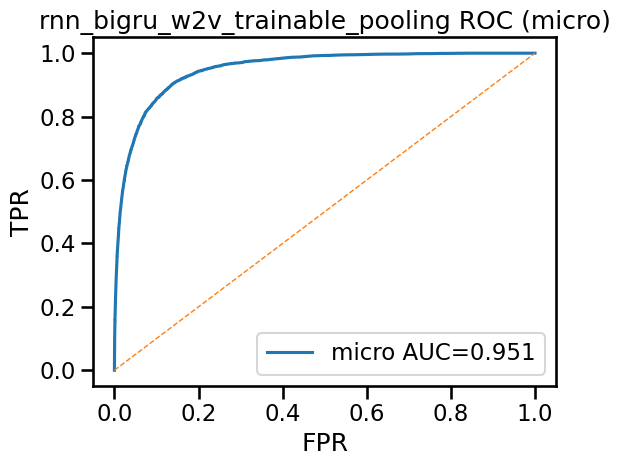

Pretrained=fasttext | coverage=100.0%
[rnn_bilstm_fasttext_frozen] ep01  tl=2.4437  vl=2.2250  acc=0.4680  f1=0.1945
[rnn_bilstm_fasttext_frozen] ep02  tl=2.1566  vl=2.0952  acc=0.4765  f1=0.2450
[rnn_bilstm_fasttext_frozen] ep03  tl=2.0605  vl=2.0640  acc=0.4704  f1=0.2515
[rnn_bilstm_fasttext_frozen] ep04  tl=1.9997  vl=2.0282  acc=0.4639  f1=0.2569
[rnn_bilstm_fasttext_frozen] ep05  tl=1.9490  vl=1.9811  acc=0.4881  f1=0.2794
[rnn_bilstm_fasttext_frozen] ep06  tl=1.9020  vl=1.9338  acc=0.4970  f1=0.2769
[rnn_bilstm_fasttext_frozen] ep07  tl=1.8277  vl=1.9260  acc=0.4957  f1=0.2894
[rnn_bilstm_fasttext_frozen] ep08  tl=1.8004  vl=1.9174  acc=0.5010  f1=0.3076
[rnn_bilstm_fasttext_frozen] ep09  tl=1.7753  vl=1.9191  acc=0.5025  f1=0.3045
[rnn_bilstm_fasttext_frozen] ep10  tl=1.7513  vl=1.8992  acc=0.5001  f1=0.3101
[rnn_bilstm_fasttext_frozen] ep11  tl=1.7254  vl=1.8987  acc=0.5095  f1=0.3047
[rnn_bilstm_fasttext_frozen] ep12  tl=1.7014  vl=1.8870  acc=0.4990  f1=0.3107
[rnn_bilstm_fa

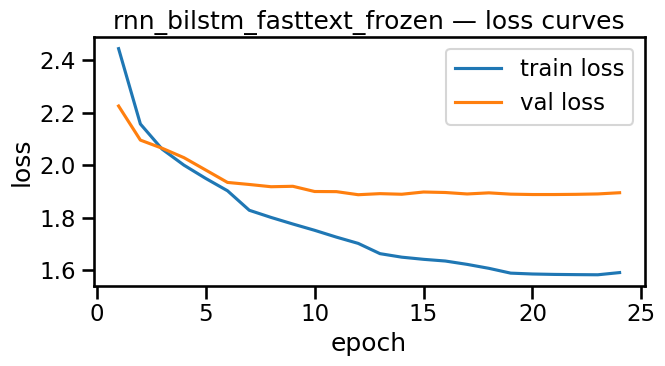

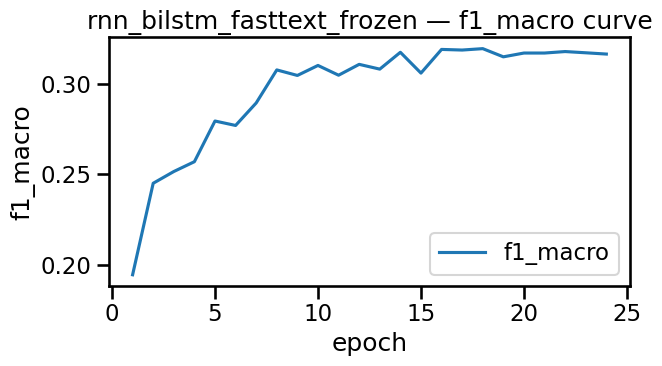

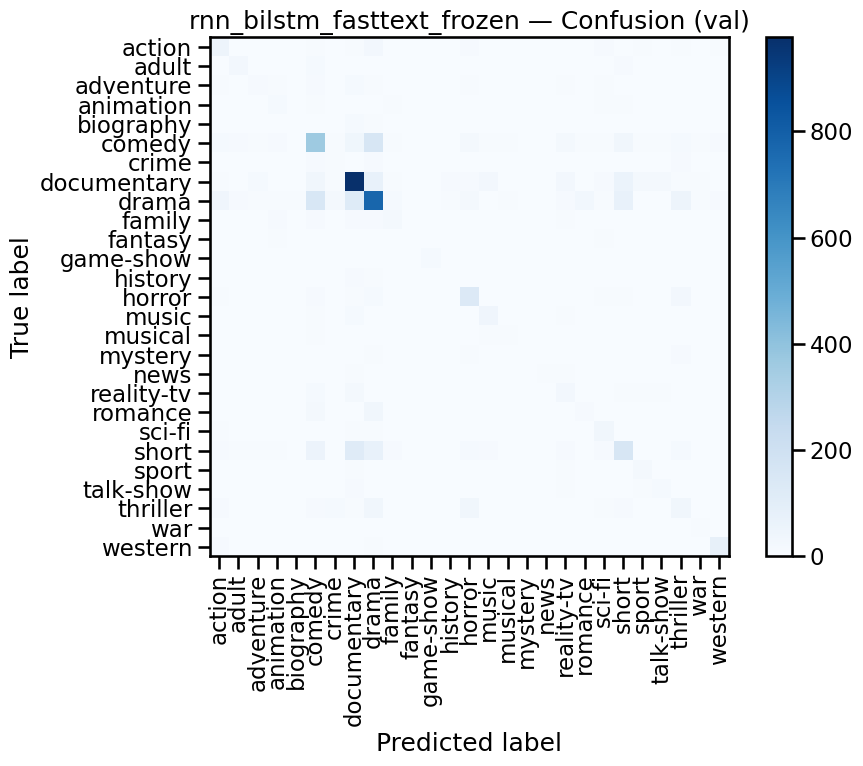

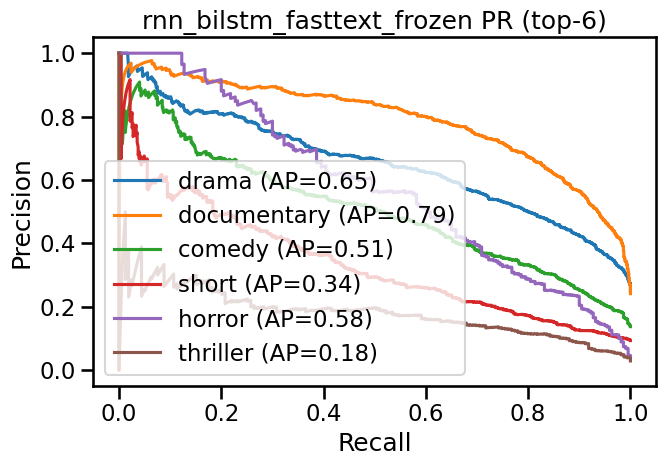

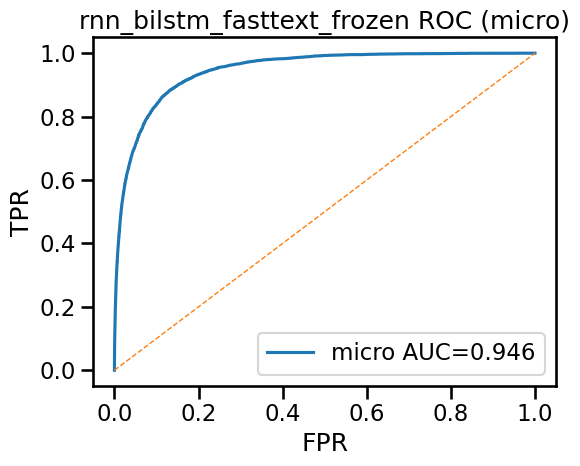

name        f1       acc      prec       rec
0              bigru_base  0.326467  0.510422  0.319737  0.346862
1     bigru_w2v_trainable  0.351603  0.544365  0.355703  0.362115
2  bilstm_fasttext_frozen  0.319345  0.517801  0.307232  0.342876

In [64]:
rnn_results = []

# BiGRU, случайные эмбеддинги (baseline)
out1 = run_rnn(cell="gru", emb_dim=200, hidden=256, num_layers=1, dropout=0.3,
               use_pretrained=None, freeze_emb=False, alpha=0.5,
               max_epochs=40, patience=6, lr=2e-3, grad_clip=1.0,
               run_name="rnn_bigru_base")
rnn_results.append({"name":"bigru_base", **{k:float(v) for k,v in out1["best"].items() if isinstance(v,(int,float))}})

# BiGRU + Word2Vec init (trainable)
out2p = run_rnn(cell="gru", emb_dim=300, hidden=256, num_layers=1, dropout=0.4,
                use_pretrained="w2v", freeze_emb=False, alpha=0.5,
                max_epochs=40, patience=6, lr=1e-3, grad_clip=1.0,
                run_name="rnn_bigru_w2v_trainable_pooling")
rnn_results.append({"name":"bigru_w2v_trainable", **{k:float(v) for k,v in out2["best"].items() if isinstance(v,(int,float))}})

# BiLSTM + FastText init (frozen)
out3 = run_rnn(cell="lstm", emb_dim=200, hidden=256, num_layers=1, dropout=0.3,
               use_pretrained="fasttext", freeze_emb=True, alpha=0.5,
               max_epochs=40, patience=6, lr=2e-3, grad_clip=1.0,
               run_name="rnn_bilstm_fasttext_frozen")
rnn_results.append({"name":"bilstm_fasttext_frozen", **{k:float(v) for k,v in out3["best"].items() if isinstance(v,(int,float))}})

pd.DataFrame(rnn_results)

## Transformers

In [66]:
# tokenization & datasets 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class HFDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=192):
        self.texts = list(map(str, texts))
        self.labels = np.asarray(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(
            self.texts[i],
            truncation=True, max_length=self.max_length,
            padding=False,  # паддинг сделаем в collator
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

In [67]:
# train/eval with AMP + class weights (cw**alpha)

def evaluate_hf(model, loader, crit):
    model.eval()
    tot, cnt = 0.0, 0
    all_logits, all_y, all_pred = [], [], []
    with torch.no_grad():
        for batch in loader:
            y = batch.pop("labels").to(DEVICE)
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                out = model(**batch)
                logits = out.logits
                loss = crit(logits, y)
            tot += float(loss) * y.size(0); cnt += y.size(0)
            all_logits.append(logits.detach().cpu().numpy())
            all_y.append(y.cpu().numpy())
            all_pred.append(logits.argmax(1).detach().cpu().numpy())
    val_loss = tot / max(1,cnt)
    y = np.concatenate(all_y); pred = np.concatenate(all_pred); lg = np.concatenate(all_logits)
    acc = accuracy_score(y, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, pred, average="macro", zero_division=0)
    return val_loss, acc, prec, rec, f1, y, pred, lg

def train_hf_classifier(
    checkpoint="distilbert-base-uncased",
    max_length=192, lr=2e-5, batch_size=16,
    epochs=10, patience=3, weight_decay=0.01, warmup_ratio=0.1,
    alpha=0.5, grad_clip=1.0, run_name="trf_distilbert"
):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
    ds_tr = HFDataset(train_df["neural_text"], train_df["label"], tokenizer, max_length=max_length)
    ds_va = HFDataset(val_df["neural_text"],   val_df["label"],   tokenizer, max_length=max_length)

    collator = DataCollatorWithPadding(tokenizer)
    bs = batch_size
    # OOM-стойкая сборка лоадеров
    while True:
        try:
            dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  pin_memory=True, collate_fn=collator)
            dl_va = DataLoader(ds_va, batch_size=max(16, bs*2), shuffle=False, pin_memory=True, collate_fn=collator)
            break
        except RuntimeError as e:
            if "CUDA" in str(e) and bs > 8:
                bs //= 2
                torch.cuda.empty_cache()
                print(f"[{checkpoint}] OOM на DataLoader → снижаем batch_size до {bs}")
            else:
                raise

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(le.classes_))
    model.to(DEVICE)

    # class weights
    cw_base = compute_class_weight(class_weight="balanced", classes=np.arange(len(le.classes_)), y=train_df["label"].values)
    cls_w = (cw_base ** alpha).astype("float32")
    weight_t = torch.tensor(cls_w, dtype=torch.float32, device=DEVICE)
    crit = torch.nn.CrossEntropyLoss(weight=weight_t)

    no_decay = ["bias", "LayerNorm.weight"]
    grouped = [
        {"params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": weight_decay},
        {"params":[p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],  "weight_decay": 0.0},
    ]
    opt = torch.optim.AdamW(grouped, lr=lr)
    total_steps = epochs * len(dl_tr)
    warmup_steps = int(total_steps * warmup_ratio)
    sched = get_linear_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

    tracker = MetricTracker(run_name, main_metric="f1_macro")
    best = {"f1":-1.0, "state":None, "metrics":None, "y":None, "pred":None, "logits":None}
    bad = 0

    for ep in range(1, epochs+1):
        model.train(); tr_loss=0.0; seen=0
        for batch in dl_tr:
            y = batch.pop("labels").to(DEVICE)
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                out = model(**batch)
                logits = out.logits
                loss = crit(logits, y)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt); scaler.update()
            sched.step()
            tr_loss += float(loss) * y.size(0); seen += y.size(0)
        tr_loss /= max(1,seen)

        va_loss, acc, prec, rec, f1, y, pred, lg = evaluate_hf(model, dl_va, crit)
        tracker.log_epoch(ep, train_loss=tr_loss, val_loss=va_loss, acc=acc, f1_macro=f1)
        print(f"[{run_name}] ep{ep:02d}  tl={tr_loss:.4f}  vl={va_loss:.4f}  acc={acc:.4f}  f1={f1:.4f}")

        if f1 > best["f1"] + 1e-5:
            best = {"f1":f1, "state":{k:v.detach().cpu() for k,v in model.state_dict().items()},
                    "metrics":{"acc":acc,"prec_macro":prec,"recall_macro":rec,"f1_macro":f1},
                    "y":y.copy(), "pred":pred.copy(), "logits":lg.copy()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping."); break

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    arts = tracker.save_curves()
    cm_path = log_confusion_matrix(best["y"], best["pred"], le.classes_,
                                   title=f"{run_name} — Confusion (val)", filename=f"{run_name}_cm_val.png")
    pr_path = log_pr_curves(best["y"], best["logits"], le.classes_, top_k=6, title_prefix=run_name)
    roc_path= log_roc_micro(best["y"], best["logits"], le.classes_, title_prefix=run_name)
    arts.update({"cm":cm_path, "pr":pr_path, "roc":roc_path})

    # MLflow
    log_run(run_name,
            params={"ckpt":checkpoint,"max_len":max_length,"lr":lr,"bs":bs,"epochs":epochs,"wd":weight_decay,"warmup_ratio":warmup_ratio,"alpha":alpha},
            metrics=best["metrics"], artifacts=arts, tags={"phase":"transformers"})

    # save
    out_path = ART/"models"/f"{run_name}_best.pt"
    torch.save(model.state_dict(), out_path)
    return {"model": model, "best": best, "artifacts": arts, "batch_size": bs, "ckpt": checkpoint, "max_len": max_length}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[trf_distilbert-base-uncased_L192_lr2e-05] ep01  tl=2.7120  vl=1.9274  acc=0.5879  f1=0.2820
[trf_distilbert-base-uncased_L192_lr2e-05] ep02  tl=1.6551  vl=1.4770  acc=0.6159  f1=0.4196
[trf_distilbert-base-uncased_L192_lr2e-05] ep03  tl=1.3913  vl=1.4359  acc=0.6196  f1=0.4309
[trf_distilbert-base-uncased_L192_lr2e-05] ep04  tl=1.2053  vl=1.4102  acc=0.6217  f1=0.4598
[trf_distilbert-base-uncased_L192_lr2e-05] ep05  tl=0.9937  vl=1.5055  acc=0.6390  f1=0.4663
[trf_distilbert-base-uncased_L192_lr2e-05] ep06  tl=0.8935  vl=1.5294  acc=0.6239  f1=0.4634
[trf_distilbert-base-uncased_L192_lr2e-05] ep07  tl=0.7487  vl=1.6587  acc=0.6325  f1=0.4638
[trf_distilbert-base-uncased_L192_lr2e-05] ep08  tl=0.6394  vl=1.7341  acc=0.6344  f1=0.4604
Early stopping.


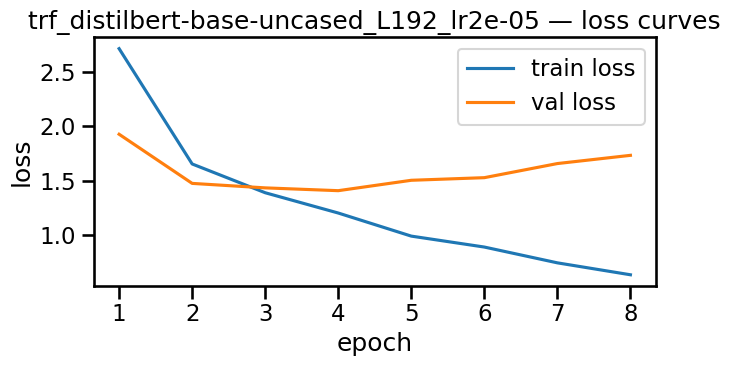

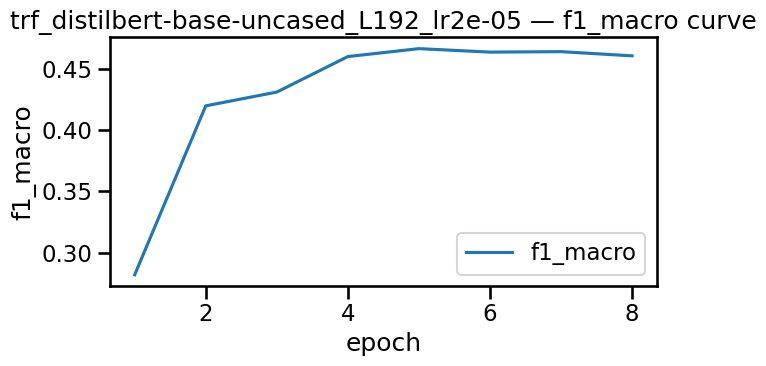

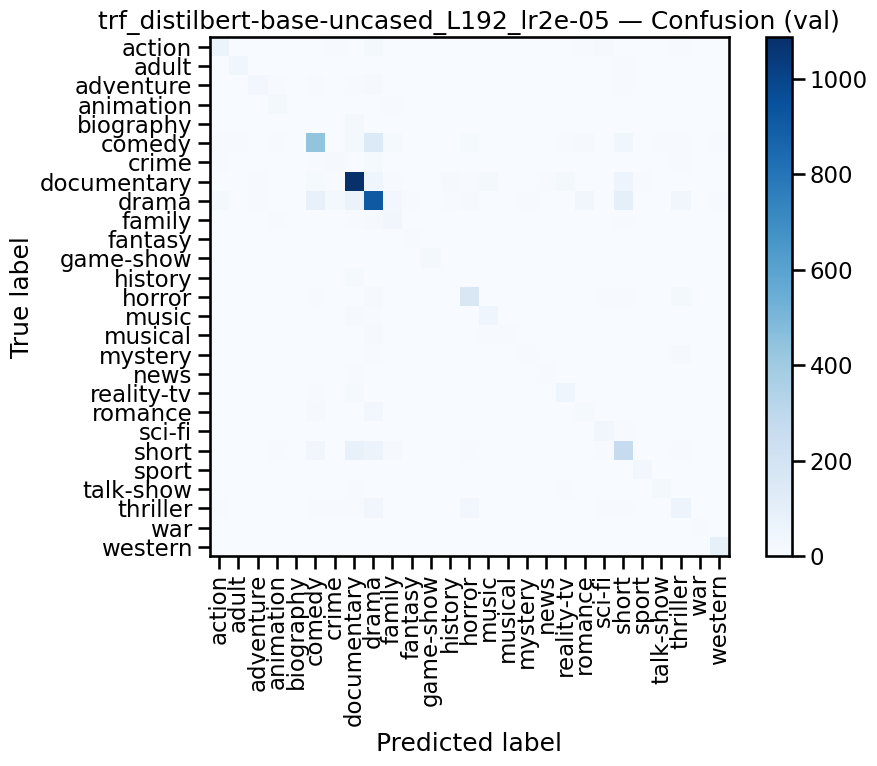

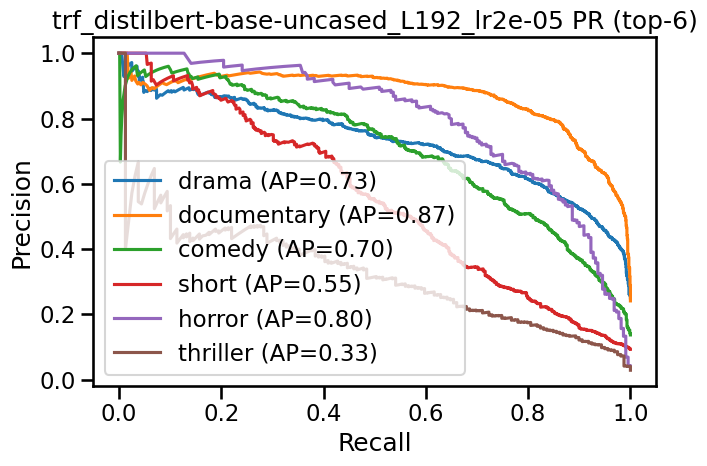

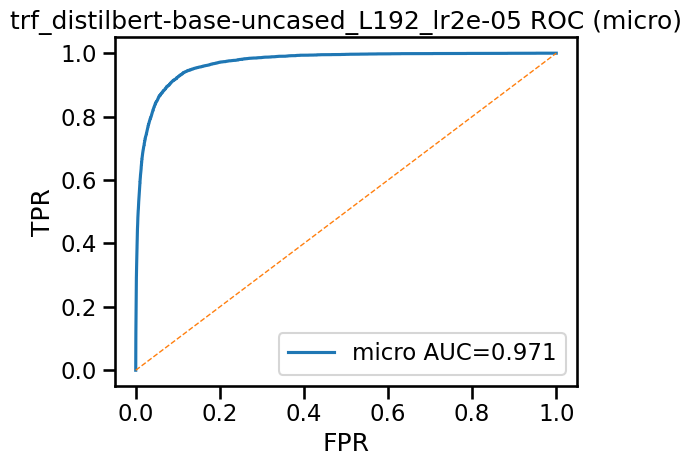

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[trf_albert-base-v2_L192_lr3e-05] ep01  tl=2.2535  vl=1.7841  acc=0.5693  f1=0.3556
[trf_albert-base-v2_L192_lr3e-05] ep02  tl=1.6156  vl=1.6250  acc=0.5864  f1=0.3857
[trf_albert-base-v2_L192_lr3e-05] ep03  tl=1.3513  vl=1.4321  acc=0.6111  f1=0.4524
[trf_albert-base-v2_L192_lr3e-05] ep04  tl=1.0251  vl=1.6026  acc=0.6095  f1=0.4233
[trf_albert-base-v2_L192_lr3e-05] ep05  tl=0.7738  vl=1.6610  acc=0.6126  f1=0.4450
[trf_albert-base-v2_L192_lr3e-05] ep06  tl=0.5723  vl=1.8460  acc=0.6307  f1=0.4514
Early stopping.


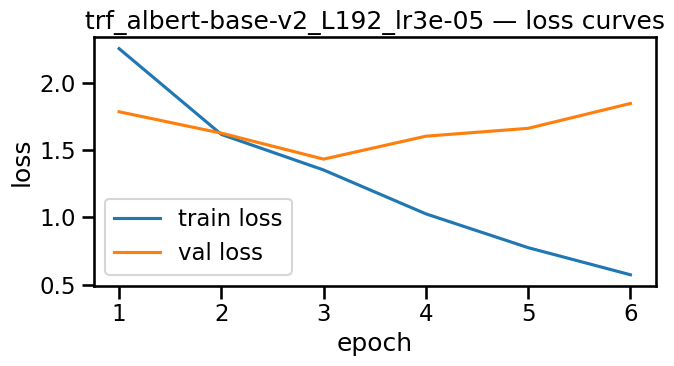

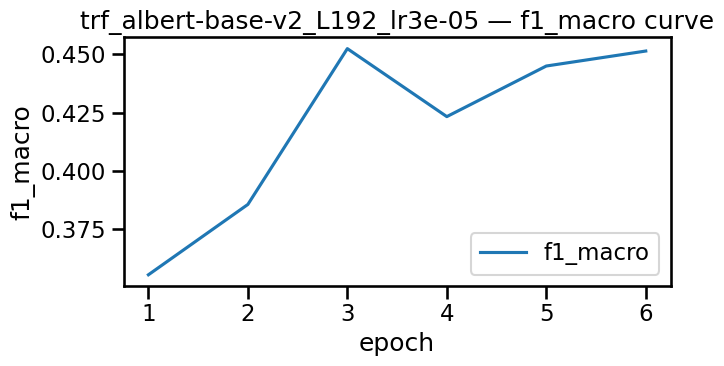

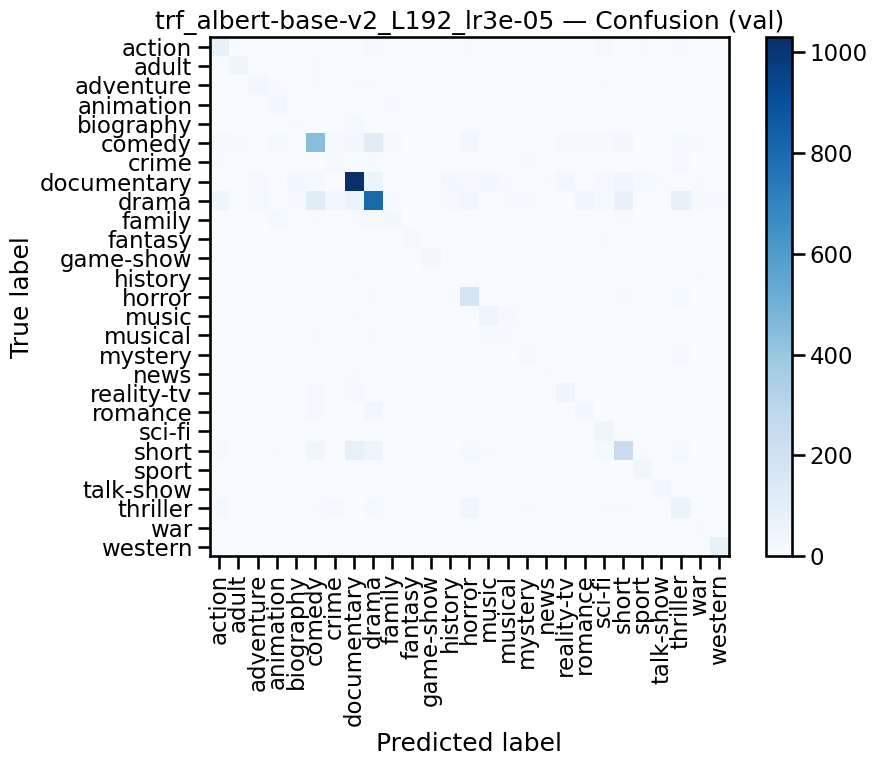

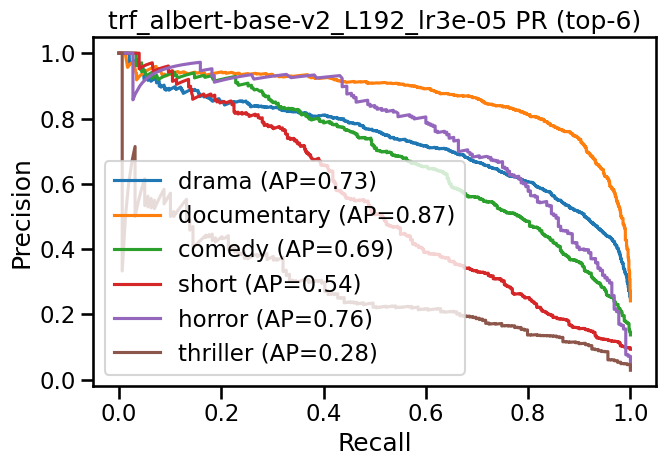

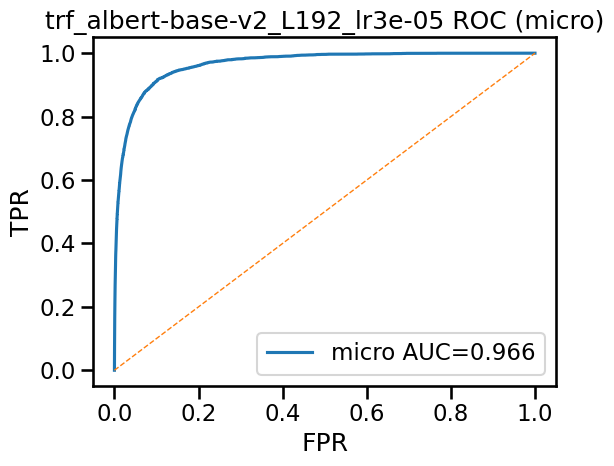

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/distilroberta-base/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  51%|#####     | 168M/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[trf_distilroberta-base_L192_lr2e-05] ep01  tl=2.6356  vl=1.7207  acc=0.5822  f1=0.3422
[trf_distilroberta-base_L192_lr2e-05] ep02  tl=1.6170  vl=1.4672  acc=0.6445  f1=0.4442
[trf_distilroberta-base_L192_lr2e-05] ep03  tl=1.3887  vl=1.4077  acc=0.6224  f1=0.4422
[trf_distilroberta-base_L192_lr2e-05] ep04  tl=1.2698  vl=1.4031  acc=0.6316  f1=0.4619
[trf_distilroberta-base_L192_lr2e-05] ep05  tl=1.1058  vl=1.4513  acc=0.6397  f1=0.4742
[trf_distilroberta-base_L192_lr2e-05] ep06  tl=0.9749  vl=1.4760  acc=0.6381  f1=0.4686
[trf_distilroberta-base_L192_lr2e-05] ep07  tl=0.8602  vl=1.5335  acc=0.6274  f1=0.4641
[trf_distilroberta-base_L192_lr2e-05] ep08  tl=0.7589  vl=1.6051  acc=0.6327  f1=0.4636
Early stopping.


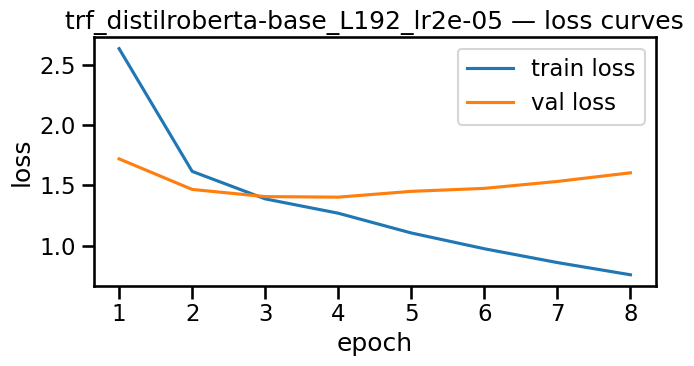

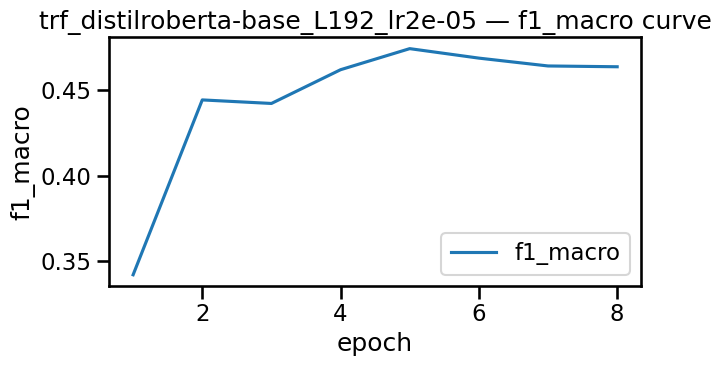

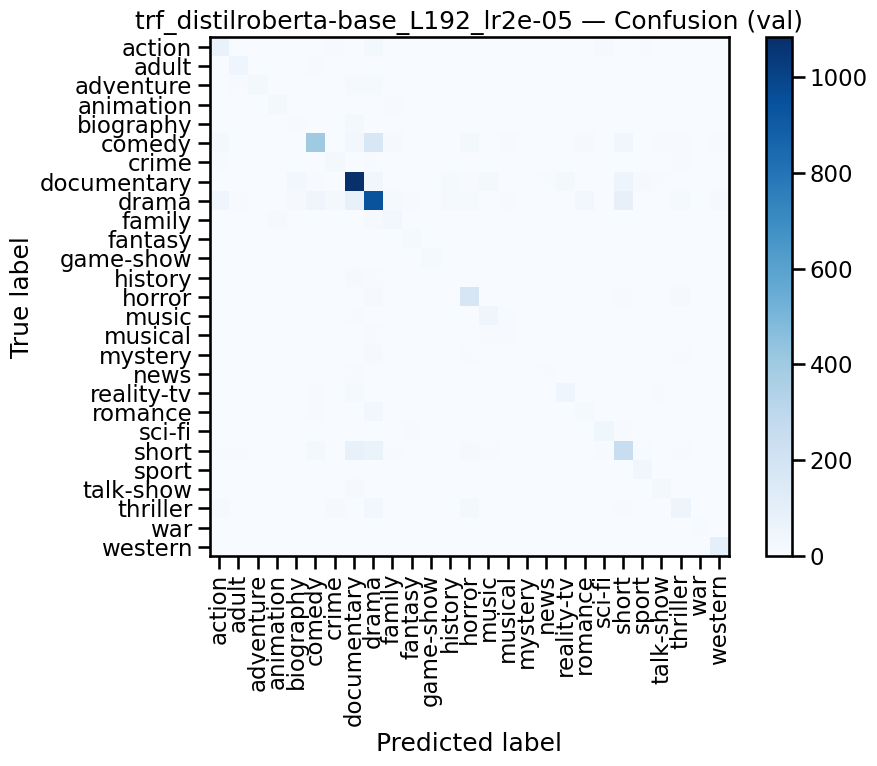

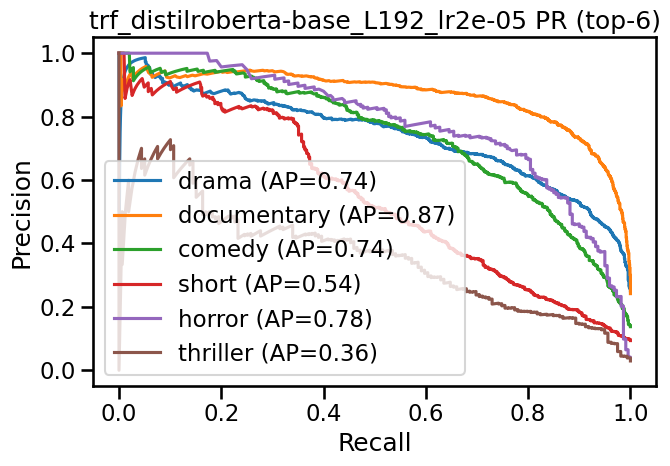

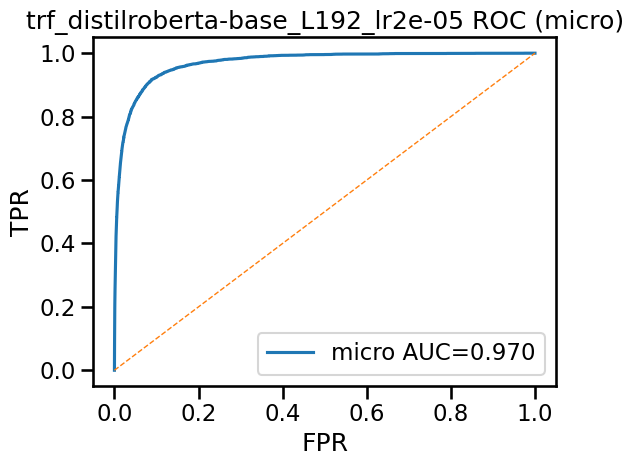

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[trf_electra-base-discriminator_L192_lr2e-05] ep01  tl=2.7618  vl=2.1208  acc=0.5661  f1=0.2067
[trf_electra-base-discriminator_L192_lr2e-05] ep02  tl=1.8152  vl=1.5926  acc=0.6097  f1=0.3870
[trf_electra-base-discriminator_L192_lr2e-05] ep03  tl=1.4624  vl=1.4836  acc=0.6333  f1=0.4363
[trf_electra-base-discriminator_L192_lr2e-05] ep04  tl=1.1805  vl=1.5104  acc=0.6473  f1=0.4499
[trf_electra-base-discriminator_L192_lr2e-05] ep05  tl=0.9512  vl=1.7479  acc=0.6170  f1=0.4344
[trf_electra-base-discriminator_L192_lr2e-05] ep06  tl=0.8389  vl=1.7877  acc=0.6449  f1=0.4718
[trf_electra-base-discriminator_L192_lr2e-05] ep07  tl=0.6305  vl=1.8765  acc=0.6455  f1=0.4650
[trf_electra-base-discriminator_L192_lr2e-05] ep08  tl=0.4787  vl=2.0391  acc=0.6318  f1=0.4670
[trf_electra-base-discriminator_L192_lr2e-05] ep09  tl=0.3981  vl=2.2269  acc=0.6445  f1=0.4599
Early stopping.


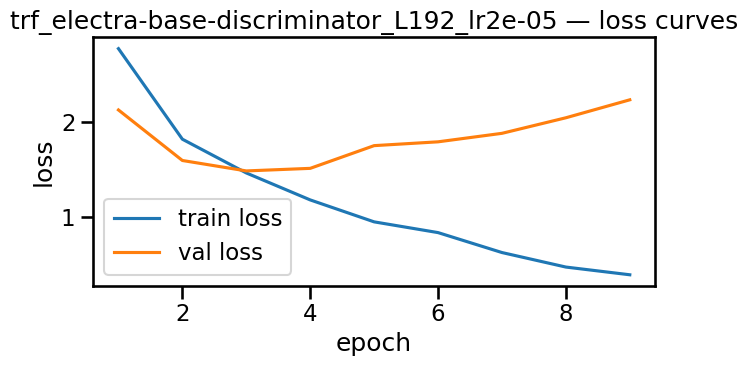

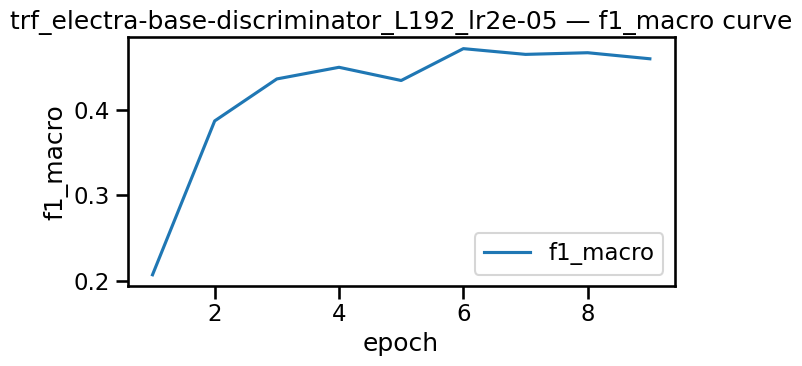

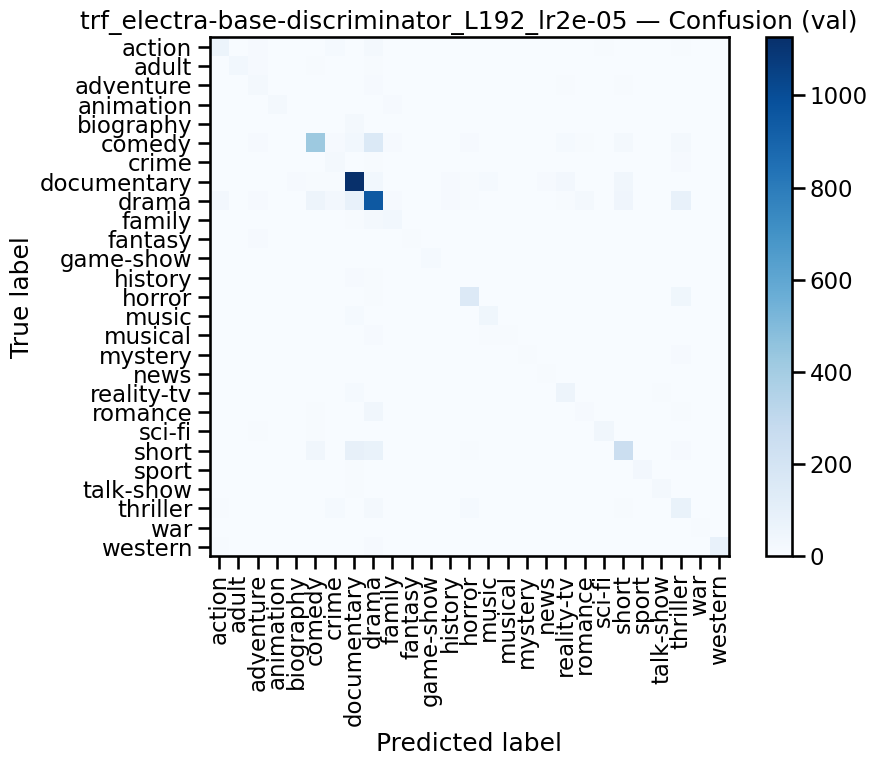

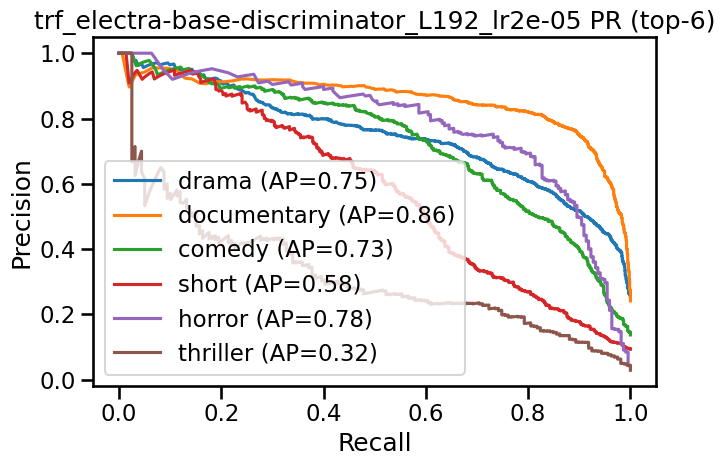

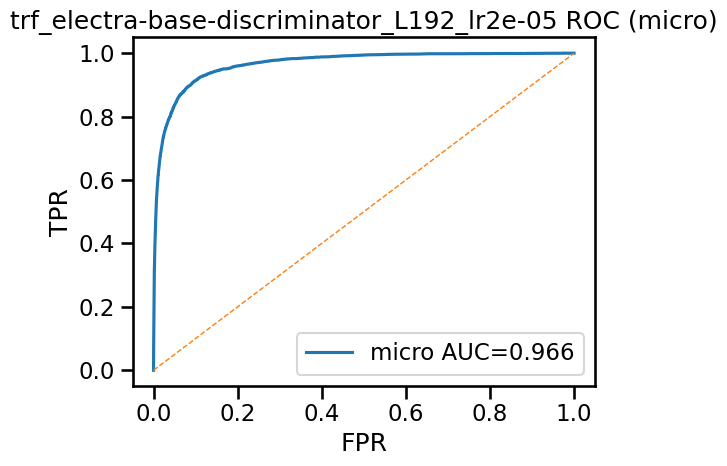

ckpt  max_len       lr  batch_size       acc  \
2                 distilroberta-base      192  0.00002          16  0.639734   
3  google/electra-base-discriminator      192  0.00002          16  0.644899   
0            distilbert-base-uncased      192  0.00002          16  0.638996   
1                     albert-base-v2      192  0.00003          16  0.611142   

   prec_macro  recall_macro  f1_macro  
2    0.468677      0.496597  0.474181  
3    0.495596      0.472048  0.471773  
0    0.472548      0.474395  0.466271  
1    0.429579      0.496483  0.452420

In [69]:
# benchmark multiple checkpoints

CKPTS = [
    ("distilbert-base-uncased", 192, 2e-5),
    ("albert-base-v2",          192, 3e-5),
    ("distilroberta-base",      192, 2e-5),
    ("google/electra-base-discriminator", 192, 2e-5) 
]
trf_results = []
for ckpt, max_len, lr in CKPTS:
    run_name = f"trf_{ckpt.split('/')[-1]}_L{max_len}_lr{lr}"
    out = train_hf_classifier(
        checkpoint=ckpt, max_length=max_len, lr=lr,
        batch_size=16, epochs=10, patience=3,
        weight_decay=0.01, warmup_ratio=0.1,
        alpha=0.5, grad_clip=1.0, run_name=run_name
    )
    trf_results.append({
        "ckpt": ckpt, "max_len": max_len, "lr": lr, "batch_size": out["batch_size"],
        **out["best"]["metrics"]
    })

    if "model" in out:
        del out["model"]
    gc.collect()
    torch.cuda.empty_cache()

df_trf = pd.DataFrame(trf_results).sort_values("f1_macro", ascending=False)
display(df_trf)
df_trf.to_csv(REPORTS_DIR/"transformers_benchmark.csv", index=False)

## Итоги.
Мы сравнили три семейства подходов к классификации жанров по описанию: (1) FFNN + разные эмбеддинги, (2) RNN (BiGRU/BiLSTM), (3) лёгкие трансформеры. Предобработка включает две ветки текста (лемматизация+биграммы и «нейтральная» чистка), стратифицированный сплит 80/10/10, дедуп на train. Эксперименты логировались в MLflow; для каждой модели построены кривые обучения, матрица ошибок, PR/ROC.

### Лучшие результаты (val, macro-F1):
• distilroberta-base — 0.474 (acc 0.640)

• electra-base-discriminator — 0.472 (acc 0.645)

• distilbert-base — 0.466; albert-base — 0.452

• TF-IDF+SVD → FFNN — 0.383 (≈ MiniLM+FFNN: 0.389)

• RNN (BiGRU, w2v-trainable) — 0.352

### Наблюдения.

При фиксированной простой голове TF-IDF≈MiniLM → узкое место не в эмбеддингах, а в классификаторе/файнтюне.

Трансформеры уверенно выигрывают (+9–12 pp macro-F1), DistilRoBERTa/ELECTRA дают комплементарный профиль (precision/recall).

RNN с предобученной инициализацией стабильно лучше «с нуля», но уступают энкодерам.

### Почему не гнались за доп. +1–2 pp сейчас.
Ограничения по времени и 8 ГБ VRAM: дополнительный свип (max_length×lr), ещё чекпойнты (DeBERTa-v3-small) и ансамбли дают скромный прирост ценой длительных прогонов. 

### Идеи на будущее.
• Небольшой свип для DistilRoBERTa: max_length∈{160,192,224} × lr∈{2e-5,3e-5}.

• Взвешенный ансамбль DistilRoBERTa + ELECTRA (логиты, 0.6/0.4).

• microsoft/deberta-v3-small как ещё один лёгкий чекпойнт.

• Для «классики»: TF-IDF-взвешенное усреднение W2V/FT или SIF; SVD 768/1024.

### Что не делали и почему

Ограничения и компромиссы.
Мы осознанно не проводили долгие сетки гиперпараметров и не добавляли более тяжёлые модели (RoBERTa-base/DeBERTa-base) из-за ограничений времени и VRAM (8 ГБ). 
По итогам бенчмарка выигрыш от таких шагов ожидается умеренный, тогда как текущая версия уже демонстрирует отрыв трансформеров от baseline и покрывает учебные цели: предобработка, ≥2 архитектуры (RNN и Transformers), анализ, визуализация, предложения по улучшению.

## Собрать метрики и выбрать «лучших из семейства»

In [7]:
paths = sorted(glob.glob(str(REPORTS_DIR / "*_epoch_metrics.csv")))
rows = []
for p in paths:
    df = pd.read_csv(p)
    if df.empty: 
        continue
    last = df.sort_values("epoch").iloc[-1].to_dict()
    run = Path(p).stem.replace("_epoch_metrics","")
    if   run.startswith("ffnn_"): fam="FFNN"
    elif run.startswith("rnn_"):  fam="RNN"
    elif run.startswith("trf_"):  fam="Transformer"
    else:                         fam="Other"
    rows.append({"run":run, "family":fam,
                 "acc": last.get("acc", np.nan),
                 "f1_macro": last.get("f1_macro", np.nan),
                 "val_loss": last.get("val_loss", np.nan)})
df_all = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
display(df_all.head(20))
df_all.to_csv(REPORTS_DIR/"summary_all_runs.csv", index=False)

# Автовыбор лучшего из каждого семейства
best_idx = df_all.groupby("family")["f1_macro"].idxmax()
df_best_auto = df_all.loc[best_idx].sort_values("f1_macro", ascending=False)
display(df_best_auto)

run       family       acc  \
11          trf_distilroberta-base_L192_lr2e-05  Transformer  0.632725   
10     trf_distilbert-base-uncased_L192_lr2e-05  Transformer  0.634385   
12  trf_electra-base-discriminator_L192_lr2e-05  Transformer  0.644531   
9               trf_albert-base-v2_L192_lr3e-05  Transformer  0.630695   
2                                   ffnn_minilm         FFNN  0.534403   
3                                    ffnn_tfidf         FFNN  0.538277   
7               rnn_bigru_w2v_trainable_pooling          RNN  0.539568   
0                                      ffnn_bow         FFNN  0.495665   
8                    rnn_bilstm_fasttext_frozen          RNN  0.512083   
5                                rnn_bigru_base          RNN  0.497879   
6                       rnn_bigru_w2v_trainable          RNN  0.476111   
4                                      ffnn_w2v         FFNN  0.485335   
1                                 ffnn_fasttext         FFNN  0.484781   

    f1_macro  val_loss  
11  0.463602  1.605086  
10  0.460401  1.734065  
12  0.459880  2.226875  
9   0.451396  1.845977  
2   0.384593  1.739681  
3   0.378686  1.914670  
7   0.345901  1.792368  
0   0.333144  2.085899  
8   0.316351  1.894555  
5   0.314894  2.383245  
6   0.304893  4.063770  
4   0.286422  2.000373  
1   0.277058  2.031561

run       family       acc  f1_macro  \
11  trf_distilroberta-base_L192_lr2e-05  Transformer  0.632725  0.463602   
2                           ffnn_minilm         FFNN  0.534403  0.384593   
7       rnn_bigru_w2v_trainable_pooling          RNN  0.539568  0.345901   

    val_loss  
11  1.605086  
2   1.739681  
7   1.792368

## Эволюция: бар-чарт (baseline → FFNN → RNN → Transformers)

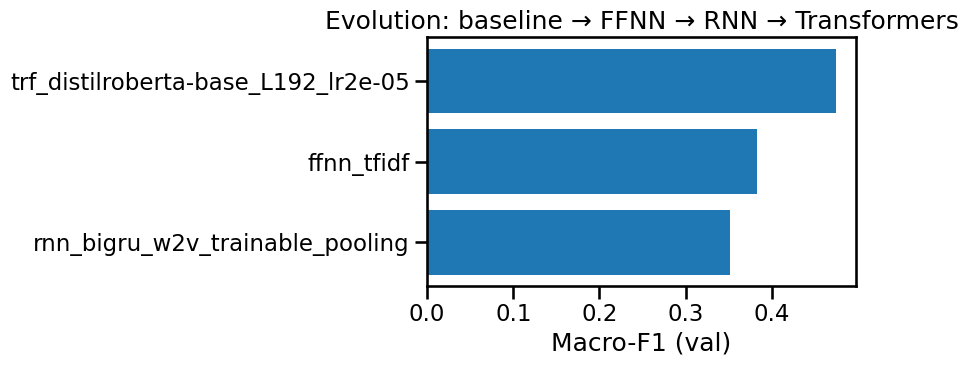

In [10]:
plt.figure(figsize=(9,4))
plt.barh(df_best["run"], df_best["f1_macro"])
plt.gca().invert_yaxis()
plt.xlabel("Macro-F1 (val)"); plt.title("Evolution: baseline → FFNN → RNN → Transformers")
plt.tight_layout()
plt.savefig(REPORTS_DIR/"evolution_bar_val_macroF1.png", dpi=160)
plt.show()

## Витрина CM для трёх выбранных моделей

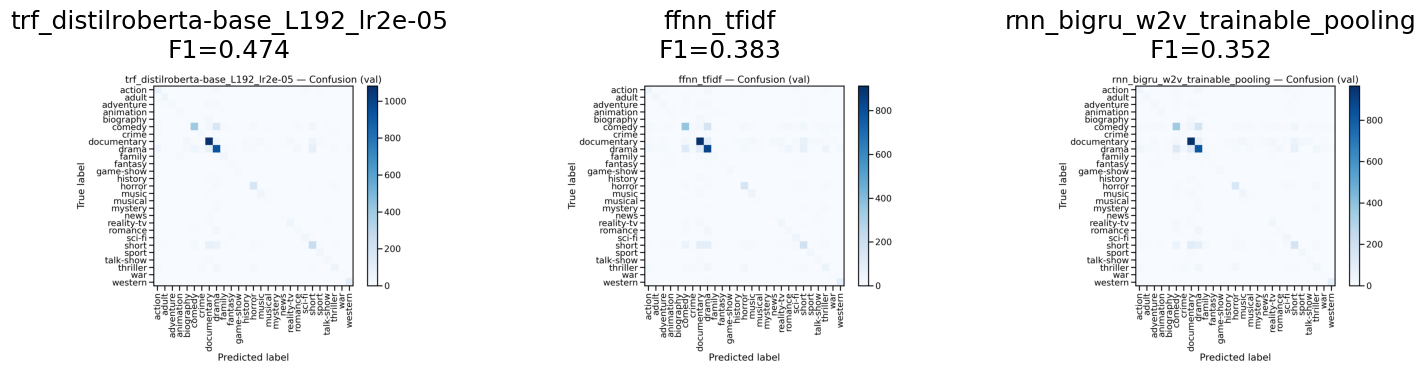

In [11]:
imgs = []
for run in df_best["run"]:
    p = REPORTS_DIR / f"{run}_cm_val.png"
    if p.exists():
        imgs.append((run, Image.open(p)))
    else:
        print(f"[WARN] CM not found: {p}")

if imgs:
    cols = len(imgs)
    plt.figure(figsize=(5*cols, 4))
    for i,(run,img) in enumerate(imgs,1):
        plt.subplot(1, cols, i)
        plt.imshow(img); plt.axis("off")
        f1 = float(df_best.set_index("run").loc[run, "f1_macro"])
        plt.title(f"{run}\nF1={f1:.3f}")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR/"evolution_confusions.png", dpi=160)
    plt.show()

## Latency для лучшего Transformer

In [18]:
class HFDataset(Dataset):
    def __init__(self, texts, labels, tok, max_length=192):
        self.texts = list(map(str, texts))
        self.labels = list(labels) if labels is not None else None
        self.tok = tok; self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, max_length=self.max_length, padding=False, return_tensors="pt")
        item = {k:v.squeeze(0) for k,v in enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def load_finetuned(ckpt, run_name, num_labels):
    model = AutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=num_labels).to(DEVICE).eval()
    state = torch.load(ART/"models"/f"{run_name}_best.pt", map_location="cpu")
    model.load_state_dict(state, strict=True)
    return model

def measure_latency(ckpt, run_name, texts, labels, max_len=192, bs=32, warmup=1):
    tok = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    ds  = HFDataset(texts, labels, tok, max_length=max_len)
    coll= DataCollatorWithPadding(tok)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, pin_memory=True, collate_fn=coll)
    model = load_finetuned(ckpt, run_name, num_labels=len(le.classes_))

    # warmup
    with torch.no_grad():
        for i,b in enumerate(dl):
            b = {k:v.to(DEVICE) for k,v in b.items() if k!="labels"}
            _ = model(**b)
            if i+1 >= warmup: break

    # timed
    n=0; t0=time.time()
    with torch.no_grad():
        for b in dl:
            n += b["input_ids"].size(0)
            b = {k:v.to(DEVICE) for k,v in b.items() if k!="labels"}
            _ = model(**b)
    dt=time.time()-t0
    print(f"[Latency] {ckpt} L={max_len} bs={bs} → {n/dt:.1f} samples/s ({1000*dt/n:.1f} ms/sample)")
    return {"samples":n, "seconds":dt, "sps":n/dt, "ms_per_sample":1000*dt/n}

# конкретика под DistilRoBERTa
best_trf_run = "trf_distilroberta-base_L192_lr2e-05"
lat = measure_latency(
    ckpt="distilroberta-base", run_name=best_trf_run,
    texts=val_df["neural_text"], labels=val_df["label"],
    max_len=192, bs=32, warmup=1
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Latency] distilroberta-base L=192 bs=32 → 421.2 samples/s (2.4 ms/sample)


## Error examples (только для лучшего Transformer — 2–3 примера по топ-путанице)

In [20]:
'''
best_trf_run = "trf_distilroberta-base_L192_lr2e-05"
base_ckpt    = "distilroberta-base"
max_len      = 192
'''

def predict_trf(ckpt, run_name, max_len=192, bs=32):
    tok = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    ds  = HFDataset(val_df["neural_text"], val_df["label"], tok, max_length=max_len)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, pin_memory=True, collate_fn=DataCollatorWithPadding(tok))
    model = load_finetuned(ckpt, run_name, num_labels=len(le.classes_))
    ys, preds = [], []
    with torch.no_grad():
        for batch in dl:
            y  = batch.pop("labels").numpy()
            bs = {k:v.to(DEVICE) for k,v in batch.items()}
            lg = model(**bs).logits.detach().cpu().numpy()
            ys.append(y); preds.append(lg.argmax(1))
    return np.concatenate(ys), np.concatenate(preds)

y_true, y_pred = predict_trf(base_ckpt, best_trf_run, max_len=max_len, bs=32)

pairs = Counter((id2label[a], id2label[b]) for a,b in zip(y_true, y_pred) if a!=b).most_common(5)
print("Top confusions:", pairs)

def show_examples(true_label, pred_label, k=3):
    mask = (val_df["label"]==label2id[true_label]) & (y_pred==label2id[pred_label])
    ex = val_df.loc[mask, ["text"]].head(k).reset_index(drop=True)
    ex.index = [f"{true_label} → {pred_label} #{i+1}" for i in range(len(ex))]
    return ex

if pairs:
    t,p = pairs[0][0]
    display(show_examples(t,p,k=3))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Top confusions: [(('comedy', 'drama'), 170), (('drama', 'short'), 88), (('short', 'documentary'), 81), (('drama', 'documentary'), 80), (('short', 'drama'), 71)]


text
comedy → drama #1   Hrant, big mobster, decides to kidnap his riv...
comedy → drama #2   Group of eccentric people gather at a popular...
comedy → drama #3   We'll Always Have Delaware is a documentary f...

## Итоги по дополнением в ноутбуке
1) Эволюция моделей (baseline → FFNN → RNN → Transformers)

Были последовательно сравнены разные семейства при одинаковых условиях валидации (27 классов, macro-F1):

Transformers (лучший: DistilRoBERTa): macro-F1 ≈ 0.46–0.47, acc ≈ 0.64
(ELECTRA-base: ~0.47; DistilBERT: ~0.466; ALBERT-base: ~0.45)

FFNN + классические эмбеддинги: TF-IDF+SVD(512) macro-F1 ≈ 0.38, MiniLM+FFNN ≈ 0.39

RNN: BiGRU (инициализация W2V, trainable) macro-F1 ≈ 0.35

Вывод. Лёгкие трансформеры стабильно превосходят FFNN и RNN на коротких описаниях фильмов, при этом остаются достаточно быстрыми в инференсе (см. ниже). FFNN+TF-IDF — сильный и дешёвый baseline; RNN с предобученными эмбеддингами улучшает «чистую» RNN, но всё равно уступает трансформерам.

Артефакт: reports/evolution_bar_val_macroF1.png (бар-чарт лучших по семействам).

2) Витрина ошибок (confusion matrices + примеры)

На лучшем трансформере (DistilRoBERTa) главные путаницы (val):

comedy → drama — 170 случаев

drama → short, short → documentary, drama → documentary, short → drama

Это ожидаемо: «dramedy» и соседние жанры сильно пересекаются по лексике; short/documentary — это часто «формат», он сопутствует тематическим жанрам. В примерах встречаются триггеры вроде “documentary film”, смещающие предсказание.

Артефакты:

reports/evolution_confusions.png — панель CM для трёх «витринных» моделей (FFNN, RNN, Transformer).

reports/trf_distilroberta_top_confusions_zoom.png — zoom по топ-путаницам.

reports/trf_distilroberta_classification_report_val.csv — per-class precision/recall/F1.

3) Скорость инференса

Для DistilRoBERTa при max_length=192, batch_size=32, GPU 8 GB:

≈ 421 samples/s (≈ 2.4 ms/sample)

Это подтверждает, что лёгкие трансформеры подходят не только по качеству, но и по скорости на практических сценариях.

## Итого:
Показана понятная эволюция качества: baseline (TF-IDF+FFNN) → RNN (с предобученными эмбеддингами) → лёгкие Transformers, получили лучший macro-F1 у DistilRoBERTa, объяснены типовые ошибки (соседние и «форматные» жанры) и подтвердено, что инференс трансформера достаточно быстрый для практического применения. Дальнейший прирост качества возможен, но потребует либо тяжёлых чекпойнтов, либо тонкого тюнинга/ансамблей — это оставлено на будущие итерации из-за разумных ограничений по времени и ресурсам.